# 1. The Data


### Passage Design
 There are 20 passages. (Although the paper by Varma & Jansen only uses 16) Each passage has 4 versions, with the differing factors being spatial/temporal:
 - near spatial/short temporal (A)
 - near spatial/long temporal (B)
 - far spatial/short temporal(C)
 - far spatial/long temporal(D)


 ### Original Study Design:
- Reading was line-by-line and self-
paced, with participants pressing the space bar to replace the current line with the next line; this enabled recording of reading times on the anaphor lines.

- Participants were encouraged to read as quickly as possible while maintaining understanding. Following each text, participants answered three comprehension questions by typing single word or phrase answers. The first queried the antecedent. The second and third queried information about locations and event order. They
were included to implicitly encourage participants to adopt the reading goal of tracking narrative space and time

In [1]:
%%capture
!pip install torch transformers
!pip install -U "huggingface_hub[cli]"

import os
os.environ["HF_HOME"] = "./hf"
os.environ["HF_HUB_CACHE"] = "./hf/hub"
os.environ['PATH'] += ':/storage/home/hcoda1/9/kzhang430/.local/bin'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set-up



# 2. Get models

We want to test on GPT-2, LLaMA-2, FlanT5, RoBERT, and Mistral-7B-v0.1 These are all open-weight models so we can get direct access to model outputs/internals to compute surprisal/attention metrics.

The huggingface token is: <REDACTED>

In [2]:
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

os.environ["HF_HOME"] = "./hf"
os.environ["HF_HUB_CACHE"] = "./hf/hub"
os.environ['PATH'] += ':/storage/home/hcoda1/9/kzhang430/.local/bin'
import numpy as np

cuda


In [3]:
# Install huggingface
# token: <REDACTED>
!hf auth whoami

user:  wristycargo


In [ ]:
from huggingface_hub import login
login()

### GPT-2

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

#tokenizer for processing text for model
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2-xl")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2-xl").to(device) #moves to device
model.config.output_attentions = True # optional if not doing attentions
model.eval()

### LLaMa-3

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B").to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## RoBERTa

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large")
model = AutoModelForMaskedLM.from_pretrained("FacebookAI/roberta-large").to(device)
model.eval()
model.config.output_attentions = True # optional if not doing attentions


## Mistral

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1", torch_dtype=torch.float16).to(device)
model.config.output_attentions = True # optional if not doing attentions

In [ ]:
model.config.output_attentions = True
model.eval()

## Mistral 24-B

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-Small-24B-Instruct-2501")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-Small-24B-Instruct-2501", torch_dtype=torch.float16).to(device)

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

# Pythia

In [ ]:
from transformers import GPTNeoXForCausalLM, AutoTokenizer

model = GPTNeoXForCausalLM.from_pretrained(
  "EleutherAI/pythia-12b-deduped",
  revision="step143000",
  cache_dir="./pythia-12b-deduped/step143000",
).to(device)

tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-12b-deduped",
  revision="step143000",
  cache_dir="./pythia-12b-deduped/step143000",
)


# GPT-4.1 (no logprobs over input, can't use this)

In [ ]:
%%capture
!pip install openai

In [ ]:
from openai import OpenAI
import torch
import math

client = OpenAI(api_key="<REDACTED>")

def score_target_with_echo(client, model, context: str, target: str):
    """
    Returns [(token, logprob)] for the target tokens, i.e., log P(target | context),
    using the Completions API with echo=True.
    """
    # 1) Tokenize+score context only
    r_ctx = client.completions.create(
        model=model,                 # e.g., "gpt-3.5-turbo-instruct" (or any model that supports Completions+echo)
        prompt=context,
        max_tokens=0,
        echo=True,
        logprobs=1,
    )
    ctx_toks = r_ctx.choices[0].logprobs.tokens
    ctx_lp   = r_ctx.choices[0].logprobs.token_logprobs

    # 2) Tokenize+score context+target
    r_full = client.completions.create(
        model=model,
        prompt=context + target,
        max_tokens=0,
        echo=True,
        logprobs=1,
    )
    full_toks = r_full.choices[0].logprobs.tokens
    full_lp   = r_full.choices[0].logprobs.token_logprobs

    # The tail part (len(ctx_toks):) corresponds to the target tokens
    tgt_toks = full_toks[len(ctx_toks):]
    tgt_lp   = full_lp[len(ctx_lp):]

    # Surprisal = -logprob (nats). For bits: divide by math.log(2).
    tgt_surprisal = [(-lp if lp is not None else float("inf")) for lp in tgt_lp]
    return list(zip(tgt_toks, tgt_surprisal))




# Gemini (no probs over input either)

In [ ]:
!pip install google-genai

In [ ]:
# <REDACTED>
from google import genai
from google.genai import types

# configure Gemini API
client = genai.Client(api_key="<REDACTED>")

def calculate_output_surprisal_gemini(
    prompt: str,
    model: str = "gemini-2.0-flash-001",
    max_output_tokens: int = 64,
    top_alternatives: int = 0,  # 0 = only chosen token surprisals
):
    """
    Return [(token, surprisal=-log_probability)] for the model's *generated* tokens.
    If you also want the top-k alternative tokens per step, set top_alternatives>=1
    and inspect the returned dict keys 'chosen' and 'top_candidates' (see code comments).
    """
    # response_logprobs turns on logprobs for chosen tokens; logprobs=N includes top-N alternatives
    cfg = types.GenerateContentConfig(
        temperature=0,  # stable outputs for analysis
        max_output_tokens=max_output_tokens,
        response_logprobs=True,            # <- required for logprobs
        logprobs=top_alternatives or None  # <- optional, 1..20 if you want alternatives
    )

    resp = client.models.generate_content(
        model=model,
        contents=prompt,
        config=cfg,
    )

    if not resp.candidates:
        return []

    cand = resp.candidates[0]

    # Average logprob over the whole candidate is available as:
    #   cand.avg_logprobs  (float)
    # Per-step details live under:
    print(cand.logprobs_result.chosen_candidates)
    #   cand.logprobs_result.top_candidates     -> list per step of alternative candidates
    lp = getattr(cand, "logprobs_result", None)
    if not lp or not getattr(lp, "chosen_candidates", None):
        return []

    surprisals = []
    for step in lp.chosen_candidates:
        token = getattr(step, "token", "")
        logp = getattr(step, "log_probability", None)
        surprisal = -(logp) if logp is not None else float("inf")
        surprisals.append((token, surprisal))

    return surprisals

# Example:
# s = calculate_output_surprisal_gemini("Explain lambda calculus in one short sentence.", max_output_tokens=40)
# print(s)





# Experiment 1: spatial and temporal distances between antecedents and anaphors

Prediction A: The greater the spatial and temporal distance between the antecedent and anaphor, the slower the anaphor reading times.
Prediction B: Temporal distance would affect reading times, with longer temporal distances leading to slower reading times.

## Experiment 1A: Surprisal

In [ ]:
def calculate_surprisal(text):
    tokens = tokenizer.encode(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(tokens)
        logits = outputs.logits


    shift_logits = logits[:, :-1, :].contiguous()
    shift_tokens = tokens[:, 1:].contiguous()

    probs = torch.softmax(shift_logits, dim=-1)

    token_probs = probs.gather(2, shift_tokens.unsqueeze(-1)).squeeze(-1)

    surprisal = -torch.log(token_probs)

    token_ids = shift_tokens[0].tolist()
    words = tokenizer.convert_ids_to_tokens(token_ids)

    aggregated_surprisal = []
    current_word = ""
    current_surprisal = 0.0
    for word, s in zip(words, surprisal[0].tolist()):
        if word.startswith("Ġ"):  # GPT-2 uses 'Ġ' to indicate a new word, Mistral uses ▁
            if current_word:
                aggregated_surprisal.append((current_word, current_surprisal))
            current_word = word.replace("Ġ", "")
            current_surprisal = s
        else:
            current_word += word
            current_surprisal += s
    if current_word:
        aggregated_surprisal.append((current_word, current_surprisal))

    return aggregated_surprisal

## Surprisal (Exp 1 - On anaphor instead)


1. **compute surprisal on the ~~whole line~~ anaphor itself**

2. presenting the words one at a time and computing surprisal on just the anaphor itself.

In [ ]:
def calculate_surprisal(text):
    tokens = tokenizer.encode(text, return_tensors='pt').to(device)


    with torch.no_grad():
        outputs = model(tokens)
        logits = outputs.logits


    shift_logits = logits[:, :-1, :].contiguous()
    shift_tokens = tokens[:, 1:].contiguous()

    probs = torch.softmax(shift_logits, dim=-1)

    token_probs = probs.gather(2, shift_tokens.unsqueeze(-1)).squeeze(-1)

    surprisal = -torch.log(token_probs)

    token_ids = shift_tokens[0].tolist()
    words = tokenizer.convert_ids_to_tokens(token_ids)

    aggregated_surprisal = []
    current_word = ""
    current_surprisal = 0.0
    for word, s in zip(words, surprisal[0].tolist()):
        if word.startswith("▁"):  # GPT-2 uses 'Ġ' to indicate a new word, Mistral uses ▁
            if current_word:
                aggregated_surprisal.append((current_word, current_surprisal))
            current_word = word.replace("▁", "")
            current_surprisal = s
        else:
            current_word += word
            current_surprisal += s
    if current_word:
        aggregated_surprisal.append((current_word, current_surprisal))

    return aggregated_surprisal

In [ ]:
# extract answers
import pandas as pd
df = pd.read_excel(f"./study 1 (context)/1 materials/scoring/question-scoring.xlsx")
answers = df[df.index % 12 == 0].Answer.to_list()

In [ ]:
answers

In [ ]:
path = './'

current_idx = 1
surprisals_res = []

while current_idx < 21:
    if current_idx < 4:
        val = 1
    elif current_idx == 4:
        current_idx += 1
        continue
    else:
        val = 2

    print(f"\n================    {current_idx}     ===============\n")

    for l in ['a', 'b', 'c', 'd']:
        print(f"\n================    {l}     ===============\n")

        with open(f"{path}/study1/version_{l}/p{str(current_idx).zfill(2)}{l.upper()}.txt", 'r') as file:
            text = file.read().replace('\n', ' ')
            processed_text = ' '.join(text.split())
            processed_text_split = processed_text.replace('.', '').replace(',', '').split()

            pre_answer_word = processed_text_split[
                processed_text_split.index(answers[current_idx - val]) - 1
            ]

            idx_of_anaphor = len(processed_text_split) - processed_text_split[::-1].index(pre_answer_word)

            surprisals = calculate_surprisal("a" + processed_text)
            # surprisals = calculate_output_surprisal_gemini = ("a" + processed_text)
            print()

            # surprise_value = sum([x[1] for x in surprisals[idx_of_anaphor-3:idx_of_anaphor+4]]) 
            # sum of surprisal of 3 words before and after the anaphor

            surprise_value = surprisals[idx_of_anaphor][1]  # the surprisal of the anaphor itself

            # print(surprisals)
            print(surprisals[idx_of_anaphor])
            print(surprise_value)

            surprisals_res.append(surprise_value)

    current_idx += 1

pd.DataFrame(surprisals_res).to_csv('surprisals_1_mistral.csv')


## Surprisal (Experiment 2)

In [ ]:
answers = ['beer',
 'uncle',
 'knife',
 'lion',
 'chair',
 'lawyer',
 'roses',
 'hammer',
 'cancer',
 'piano',
 'sailboat',
 'table',
 'dog',
 'apples',
 'magazine',
 'knife',
 'shirt',
 'diamonds',
 'shirt']

In [ ]:
path = './study2'

current_idx = 1
surprisals_res = []

while current_idx < 21:
    if current_idx < 4:
        val = 1
    elif current_idx == 4:
        current_idx += 1
        continue
    else:
        val = 2

    print(f"\n================    {current_idx}     ===============\n")

    for l in ['a', 'b', 'c', 'd']:
        print(f"\n================    {l}     ===============\n")
        with open(f"{path}/version_{l}/p{str(current_idx).zfill(2)}{l}.txt", 'r') as file:
            text = file.read().replace('\n', ' ')
            processed_text = ' '.join(text.split())

            print()

            word1 = answers[current_idx - val]
            word_list = (
                processed_text
                .replace('.', '')
                .replace(',', '')
                .replace('!', '')
                .replace('?', '')
                .split()
            )

            if l == 'a':
                word1_i = word_list.index(word1)
            word11 = word_list[word1_i - 1]  # amber
            word2_i = word_list[::-1].index(word11)

            # need to add "a" so that it properly starts tokenizing at the first line
            surprisals = calculate_surprisal("a" + processed_text)

            idx_of_anaphor = len(word_list) - word_list[::-1].index(word11)
            print(surprisals[idx_of_anaphor])

            # surprise_value = sum(
            #     [x[1] for x in surprisals[idx_of_anaphor - 3 : idx_of_anaphor + 4]]
            # )
            surprise_value = surprisals[idx_of_anaphor][1]
            print(surprise_value)

            surprisals_res.append(surprise_value)

    current_idx += 1

pd.DataFrame(surprisals_res).to_csv('surprisals_2_mistral.csv')


# O'Brien Texts

In [5]:
def calculate_surprisal(text):
    tokens = tokenizer.encode(text, return_tensors='pt').to(device)


    with torch.no_grad():
        outputs = model(tokens)
        logits = outputs.logits


    shift_logits = logits[:, :-1, :].contiguous()
    shift_tokens = tokens[:, 1:].contiguous()

    probs = torch.softmax(shift_logits, dim=-1)

    token_probs = probs.gather(2, shift_tokens.unsqueeze(-1)).squeeze(-1)

    surprisal = -torch.log(token_probs)

    token_ids = shift_tokens[0].tolist()
    words = tokenizer.convert_ids_to_tokens(token_ids)

    aggregated_surprisal = []
    current_word = ""
    current_surprisal = 0.0
    for word, s in zip(words, surprisal[0].tolist()):
        if word.startswith("Ġ"):  # GPT-2 uses 'Ġ' to indicate a new word, Mistral uses ▁
            if current_word:
                aggregated_surprisal.append((current_word, current_surprisal))
            current_word = word.replace("Ġ", "")
            current_surprisal = s
        else:
            current_word += word
            current_surprisal += s
    if current_word:
        aggregated_surprisal.append((current_word, current_surprisal))

    return aggregated_surprisal

def ana_token_count(ana: str) -> int:
    # Add a leading space so the tokenization matches how it appears in full_text
    return len(tokenizer.encode(" " + ana, add_special_tokens=False))

### Surprisal

In [ ]:
# import string

# data = []
# anaphor_idxs = [['driving', 'bought'], ['broken', 'asked'], ['given', 'found'], 
#                 ['broken', 'stolen'], ['carrying', 'spoken'], ['forgotten', 'spilled'], 
#                 ['rank', 'profession'], ['daughter', 'bakery'], ['fix', 'eat'],
#                 ['seen', 'eaten'], ['drink', 'television'], ['work', 'picked'], 
#                 ['carried', 'put'], ['window', 'gone'], ['burned', 'found'],
#                 ['murder', 'stolen']]

# for i in range(1, 17):
#     with open(f"{i}.txt", "r") as file:
#         lines = file.readlines()[1:]
#         modified = []
#         for line in lines:
#             modified_line = line.replace("1", lines[2]).replace("2", lines[3])
#             modified.append(modified_line)

#         title_1 = lines[0]
#         title_2 = lines[1]
#         anaphor_1 = lines[4]
#         anaphor_2 = lines[5]

#         # Generate four versions based on instructions

#         # Version A: matching title, high distance
#         # B: unmatching title, low distance
#         # C: unmatching title, high distance
#         # D: matching title, low distance
#         versions = [
#             [title_1] + modified[10:-1] + [anaphor_1],
#             [title_1] + modified[10:-1] + [anaphor_2],
#             [title_2] + modified[10:-1] + [anaphor_1],
#             [title_2] + modified[10:-1] + [anaphor_2],
#         ]
#         def norm(tok: str) -> str:
#             return tok.strip().lower().strip(string.punctuation)

#         for j, version in enumerate(versions):
#             full_text = "".join(version)
#             full_text = full_text.replace("\n", " ").replace("  ", " ").replace("  ", " ")
#             surprisals = calculate_surprisal(full_text)

#             # Decide which anaphor we used (last line of `version`)
#             anaphor = version[-1]
#             anaphor_tokens = len(anaphor.strip().split())  # count words or tokens

#             # Take the last `anaphor_tokens` surprisals and normalize keys
#             last_surprisals_raw = surprisals[-anaphor_tokens:]          # e.g. list of (token, value)
#             last_surprisals = {norm(tok): val for tok, val in last_surprisals_raw}

#             # Which anaphor word do we want the surprisal for?
#             target_word = anaphor_idxs[i-1][j % 2]
#             key = norm(target_word)

#             # Look it up robustly
#             if key not in last_surprisals:
#                 # Fall back: try the last token of the anaphor line, or print what we do have
#                 # (optional) print for debugging:
#                 print("Available keys:", list(last_surprisals.keys()))
#                 # As a conservative fallback, take the final token’s surprisal:
#                 fallback_key = norm(anaphor.strip().split()[-1])
#                 anaphor_surprisal = last_surprisals.get(fallback_key)
#             else:
#                 anaphor_surprisal = last_surprisals[key]

#             # print(last_surprisals)
#             # print(anaphor_surprisal)
#             data.append(anaphor_surprisal)

In [ ]:
data = []

for i in range(1, 17):
    with open(f"study3/{i}.txt", "r") as file:
        lines = file.readlines()
        modified = []
        for line in lines[1:]:
            modified_line = line.replace("1", lines[2]).replace("2", lines[3])
            modified.append(modified_line)

        title_1 = modified[0].strip()
        title_2 = modified[1].strip()
        sentence_1 = modified[2].strip()
        sentence_2 = modified[3].strip()
        anaphor_1 = modified[4].strip()
        anaphor_2 = modified[5].strip()
        

        # Shared body content (not including title/anaphor)
        body = modified[10:-1]

        # Full versions for surprisal extraction
        versions = [
            [title_2] + body + [anaphor_2], # high topicality, low distance
            [title_1] + body + [anaphor_2], # low topicality, low distance
            [title_1] + body + [anaphor_1], # high topicality, high distance
            [title_2] + body + [anaphor_1], # low topicality, high distance
            
        ]
        
        # print(title_1, title_2, anaphor_1, anaphor_2)
        anaphors = [anaphor_2, anaphor_2, anaphor_1, anaphor_1]

        for version, ana in zip(versions, anaphors) :
            full_text = " ".join(line.strip() for line in version)
            full_text = full_text.replace("  ", " ").replace("Ċ", "")
            
            

            prefix = " ".join(line.strip() for line in version[:-1])
            ana = version[-1].strip()

            # Ensure full_text has exactly one space before the anaphor (to match the count function)
            full_text = (prefix + " " + ana).replace("  ", " ").replace("Ċ", "")
            
            # print(full_text)


            # 1) token-level surprisals for the whole sequence
            tok_surp = calculate_surprisal(full_text)
            
            # print(tok_surp)

            # 2) how many tokens the anaphor contributes at the end
            n_ana_tokens = ana_token_count(ana)

            # 3) mean surprisal over the anaphor tokens
            results = float(np.mean([s[1] for s in tok_surp[-n_ana_tokens:]]))
            
            # print(tok_surp[-n_ana_tokens:])

            data.append(results)


data = pd.DataFrame(data)
data.to_csv("surprisals_3_llama3.csv")

# Graphing Code

In [ ]:
data = pd.read_csv("exp1.csv")
data_p = pd.DataFrame(data)

# Add a column indicating passage type based on the row index
passages = ['A', 'B', 'C', 'D'] * (len(data_p) // 4 + 1)
data_p['Passage'] = passages[:len(data)]

# data_p

# print(data_p)

group_number = []
current_group = 1

for i in range(len(data_p)):
    if i % 4 == 0 and i != 0:  # Change group every 4 rows
        current_group += 1
    group_number.append(current_group)

data_p["Group"] = group_number

normalized = data_p.groupby("Group").transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Keep metadata
df_normalized = pd.concat([data_p[['Passage','Group']], normalized], axis=1)

data_p = df_normalized
# print(data_p)

# data_p["Normalized"] = data_p.groupby("Group")["Surprisal"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# print(data_p)

stats = data_p.groupby("Passage").agg(["mean", "sem"])

# if you only want the models (exclude Group column from stats)
model_stats = stats.drop(columns=["Group"], errors="ignore")


stats=model_stats



# Assume your dataframe is called stats
models = stats.columns.levels[0][1:]   # GPT2, RoBERTa, Mistral-7B, etc.
passages = ['A', 'C', 'B', 'D']        # <-- swapped B and C here
x = np.arange(len(models))             # x positions for models

width = 0.18  # width of each bar

plt.figure(figsize=(12, 6))

for i, passage in enumerate(passages):
    means = [stats[model]["mean"].loc[passage] for model in models]
    sems = [stats[model]["sem"].loc[passage] for model in models]
    
    plt.bar(
        x + i*width,
        means,
        width,
        yerr=sems,
        capsize=4,
        label=passage,   # temp label, legend clarified below
        alpha=0.85
    )

# Center ticks
plt.xticks(x + width*(len(passages)-1)/2, models, rotation=45)

plt.xlabel("Models")
plt.ylabel("Mean surprisal (± SEM)")
plt.title("Model Surprisal (exp1)")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Custom legend mapping
legend_labels = {
    "A": "near spatial distance, short temporal duration",
    "C": "near spatial distance, long temporal duration",
    "B": "far spatial distance, short temporal duration",
    "D": "far spatial distance, long temporal duration"
}

# Create custom legend handles
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [legend_labels[l] for l in labels]

plt.legend(
    handles, 
    new_labels, 
    title="Passages",
    bbox_to_anchor=(1.01, 0.5),
    loc="center left",
    borderaxespad=0.
)

plt.tight_layout(rect=[0, 0, 1.2, 1])
plt.show()




/tmp/ipykernel_108516/2413524549.py:22: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  normalized = data_p.groupby("Group").transform(


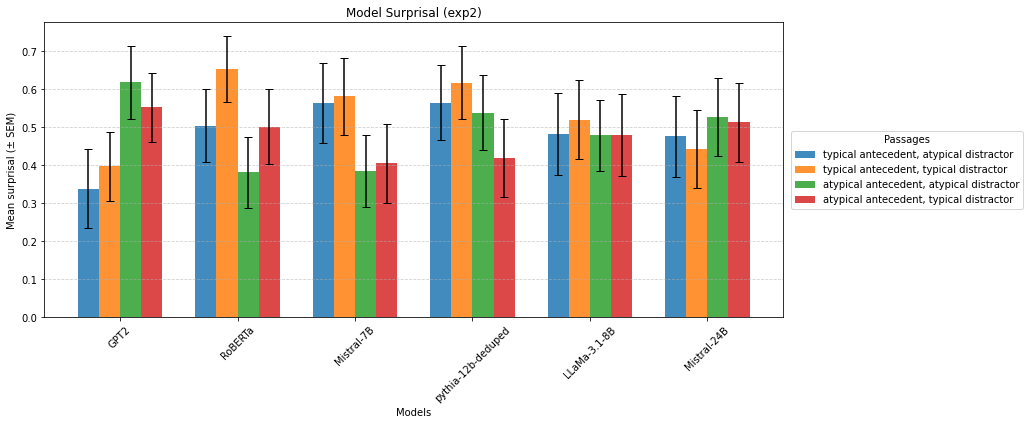

In [12]:
data = pd.read_csv("exp2.csv")
data_p = pd.DataFrame(data)

# Add a column indicating passage type based on the row index
passages = ['A', 'B', 'C', 'D'] * (len(data_p) // 4 + 1)
data_p['Passage'] = passages[:len(data)]

# data_p

# print(data_p)

group_number = []
current_group = 1

for i in range(len(data_p)):
    if i % 4 == 0 and i != 0:  # Change group every 4 rows
        current_group += 1
    group_number.append(current_group)

data_p["Group"] = group_number

normalized = data_p.groupby("Group").transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Keep metadata
df_normalized = pd.concat([data_p[['Passage','Group']], normalized], axis=1)

data_p = df_normalized
# print(data_p)

# data_p["Normalized"] = data_p.groupby("Group")["Surprisal"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# print(data_p)

stats = data_p.groupby("Passage").agg(["mean", "sem"])

# if you only want the models (exclude Group column from stats)
model_stats = stats.drop(columns=["Group"], errors="ignore")


stats=model_stats



# Assume your dataframe is called stats
models = stats.columns.levels[0][1:]   # GPT2, RoBERTa, Mistral-7B, etc.
passages = ['B', 'A', 'D', 'C']        # <-- swapped B and C here
x = np.arange(len(models))             # x positions for models

width = 0.18  # width of each bar

plt.figure(figsize=(12, 6))

for i, passage in enumerate(passages):
    means = [stats[model]["mean"].loc[passage] for model in models]
    sems = [stats[model]["sem"].loc[passage] for model in models]
    
    plt.bar(
        x + i*width,
        means,
        width,
        yerr=sems,
        capsize=4,
        label=passage,   # temp label, legend clarified below
        alpha=0.85
    )

# Center ticks
plt.xticks(x + width*(len(passages)-1)/2, models, rotation=45)

plt.xlabel("Models")
plt.ylabel("Mean surprisal (± SEM)")
plt.title("Model Surprisal (exp2)")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Custom legend mapping
legend_labels = {
    "B": "typical antecedent, atypical distractor", 

"A": "typical antecedent, typical distractor",

"D": "atypical antecedent, atypical distractor", 

"C": "atypical antecedent, typical distractor", 
}

# Create custom legend handles
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [legend_labels[l] for l in labels]

plt.legend(
    handles, 
    new_labels, 
    title="Passages",
    bbox_to_anchor=(1.01, 0.5),
    loc="center left",
    borderaxespad=0.
)

plt.tight_layout(rect=[0, 0, 1.2, 1])
plt.show()




/tmp/ipykernel_108516/2267468801.py:22: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  normalized = data_p.groupby("Group").transform(


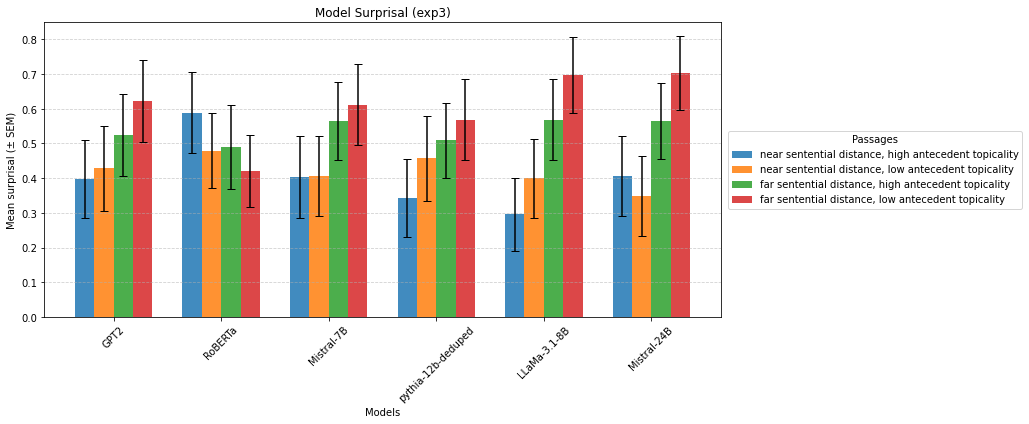

In [14]:
data = pd.read_csv("exp3.csv")
data_p = pd.DataFrame(data)

# Add a column indicating passage type based on the row index
passages = ['A', 'B', 'C', 'D'] * (len(data_p) // 4 + 1)
data_p['Passage'] = passages[:len(data)]

# data_p

# print(data_p)

group_number = []
current_group = 1

for i in range(len(data_p)):
    if i % 4 == 0 and i != 0:  # Change group every 4 rows
        current_group += 1
    group_number.append(current_group)

data_p["Group"] = group_number

normalized = data_p.groupby("Group").transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Keep metadata
df_normalized = pd.concat([data_p[['Passage','Group']], normalized], axis=1)

data_p = df_normalized
# print(data_p)

# data_p["Normalized"] = data_p.groupby("Group")["Surprisal"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# print(data_p)

stats = data_p.groupby("Passage").agg(["mean", "sem"])

# if you only want the models (exclude Group column from stats)
model_stats = stats.drop(columns=["Group"], errors="ignore")


stats=model_stats



# Assume your dataframe is called stats
models = stats.columns.levels[0][1:]   # GPT2, RoBERTa, Mistral-7B, etc.
passages = ['A', 'B', 'C', 'D']        # <-- swapped B and C here
x = np.arange(len(models))             # x positions for models

width = 0.18  # width of each bar

plt.figure(figsize=(12, 6))

for i, passage in enumerate(passages):
    means = [stats[model]["mean"].loc[passage] for model in models]
    sems = [stats[model]["sem"].loc[passage] for model in models]
    
    plt.bar(
        x + i*width,
        means,
        width,
        yerr=sems,
        capsize=4,
        label=passage,   # temp label, legend clarified below
        alpha=0.85
    )

# Center ticks
plt.xticks(x + width*(len(passages)-1)/2, models, rotation=45)

plt.xlabel("Models")
plt.ylabel("Mean surprisal (± SEM)")
plt.title("Model Surprisal (exp3)")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Custom legend mapping
legend_labels = {
"A": "near sentential distance, high antecedent topicality", 

"B": "near sentential distance, low antecedent topicality", 

"C": "far sentential distance, high antecedent topicality", 

"D": "far sentential distance, low antecedent topicality" 

 
}

# Create custom legend handles
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [legend_labels[l] for l in labels]

plt.legend(
    handles, 
    new_labels, 
    title="Passages",
    bbox_to_anchor=(1.01, 0.5),
    loc="center left",
    borderaxespad=0.
)

plt.tight_layout(rect=[0, 0, 1.2, 1])
plt.show()




### Comprehension

In [ ]:
data = []
for i in range(1, 17):
  with open(f"{i}.txt", "r") as file:
    lines = file.readlines()[1:]
    modified = []
    for line in lines:
      modified_line = line.replace("1", lines[2]).replace("2", lines[3])
      modified.append(modified_line)

    title_1 = lines[0]
    title_2 = lines[1]
    anaphor_1 = lines[4]
    anaphor_2 = lines[5]


    question_1 = lines[6]
    question_2 = lines[7]
    question_3 = lines[8]
    question_4 = lines[9]

    questions = [question_1, question_2, question_3, question_4]

    # Create prompt template
    def make_prompt(story, anaphor, questions):
        return f"""\
    TEXT:
    {story} {anaphor}

    QUESTIONS:
    1. {questions[0]}
    2. {questions[1]}
    3. {questions[2]}
    4. {questions[3]}

    INSTRUCTIONS:
    Answer the four questions above in short, direct answers. Do not repeat the story or questions. Just list the answers as 1., 2., 3., 4.
    """

    # Prepare the story text
    body = "".join(modified[10:-1])  # common to all versions

    # Now define each of the 4 versions
    prompts = []

    # Version A: matching title, high distance
    story_A = f"{title_1}{body}"
    prompts.append(make_prompt(story_A, anaphor_1, questions))

    # Version B: matching title, low distance
    story_B = f"{title_1}{body}"
    prompts.append(make_prompt(story_B, anaphor_2, questions))

    # Version C: unmatching title, high distance
    story_C = f"{title_2}{body}"
    prompts.append(make_prompt(story_C, anaphor_1, questions))

    # Version D: unmatching title, low distance
    story_D = f"{title_2}{body}"
    prompts.append(make_prompt(story_D, anaphor_2, questions))




    # Generate four versions based on instructions

    # Version A: matching title, high distance
    # B: unmatching title, low distance
    # C: unmatching title, high distance
    # D: matching title, low distance


    for i in prompts:
      print(i)
      a = i.replace('\n', ' ').replace('  ', ' ').replace('  ', ' ')
      # Tokenization
      inputs = tokenizer(a, return_tensors="pt", truncation=True, max_length=1024).to(device)

      # Model inference
      with torch.no_grad():
          outputs = model.generate(**inputs, max_length=1024, temperature=0, top_p=0.9)

      # Decoding the output
      response = tokenizer.decode(outputs[0], skip_special_tokens=True)

      # Store the results
      data.append({"response": response})
      print(response)




In [ ]:
import torch, json, csv
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1 )  Load model & tokenizer
model_name = "gpt2-xl"
tokenizer   = AutoTokenizer.from_pretrained(model_name)
model       = AutoModelForCausalLM.from_pretrained(model_name).to(device)
eos_id      = tokenizer.eos_token_id   # GPT-2’s  token_id = 50256

In [ ]:
# 2 )  Helper for prompt construction
def make_prompt(story: str, anaphor: str, questions: list[str]) -> str:
    return (
f"### STORY\n{story} {anaphor}\n\n"
f"### QUESTIONS\n"
f"1) {questions[0]}\n"
f"2) {questions[1]}\n"
f"3) {questions[2]}\n"
f"4) {questions[3]}\n\n"
"### FORMAT\n"
"Write the answers only, one per line, numbered 1-4.\n\n"
"### ANSWERS\n"
    )

# 3 )  Main loop over the 16 files
results = []          # will hold dicts that we later dump to CSV / JSON

for idx in range(1, 17):
    lines = Path(f"{idx}.txt").read_text(encoding="utf-8").splitlines()

    # --- unpack file content -------------------------------------------------
    title_1, title_2   = lines[0], lines[1]
    anaphor_1, anaphor_2 = lines[4], lines[5]
    questions          = [lines[6], lines[7], lines[8], lines[9]]

    # Replace placeholder “1” / “2” inside the story body
    body_raw = lines[10:]                      # the remainder of the story
    body     = "".join(
        l.replace("1", lines[2]).replace("2", lines[3]) for l in body_raw
    ).strip()

    # --- four experimental versions -----------------------------------------
    versions = [
        ("A", title_1, anaphor_1),  # matching title, high distance
        ("B", title_1, anaphor_2),  # matching title, low  distance
        ("C", title_2, anaphor_1),  # unmatching title, high distance
        ("D", title_2, anaphor_2),  # unmatching title, low  distance
    ]

    for label, title, anaphor in versions:
        prompt = make_prompt(f"{title} {body}", anaphor, questions)

        # --- run GPT-2 -------------------------------------------------------
        enc = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            out_ids = model.generate(
                **enc,
                max_new_tokens        = 60,   # plenty for four short answers
                temperature           = 0.7,  # >0 to avoid greedy loops
                top_p                 = 0.9,
                repetition_penalty    = 1.2,  # discourages echoing
                eos_token_id          = eos_id,
                pad_token_id          = eos_id,
            )

        answer_block = tokenizer.decode(
            out_ids[0][enc.input_ids.shape[-1]:],  # strip the prompt
            skip_special_tokens=True
        ).strip()

        results.append(
            {"file": idx, "version": label, "answers": answer_block}
        )
        print(f"{idx:02d}{label} → {answer_block}")

# 4 )  Persist results --------------------------------------------------------
# As CSV (easy for Excel / R) …
with open("gpt2xl_answers.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=results[0].keys())
    writer.writeheader(); writer.writerows(results)

# … and as JSON (keeps the list structure intact)
Path("gpt2xl_answers.json").write_text(json.dumps(results, indent=2, ensure_ascii=False))

print("\nDone!  Answers saved to gpt2xl_answers.[csv|json]")


### Attention

In [ ]:
data = []
for i in range(1, 17):
  with open(f"{i}.txt", "r") as file:
    lines = file.readlines()[1:]
    modified = []
    for line in lines:
      modified_line = line.replace("1", lines[2]).replace("2", lines[3])
      modified.append(modified_line)

    title_1 = lines[0]
    title_2 = lines[1]
    anaphor_1 = lines[4]
    anaphor_2 = lines[5]




    # Generate four versions based on instructions

    # Version A: matching title, high distance
    # B: unmatching title, low distance
    # C: unmatching title, high distance
    # D: matching title, low distance
    versions = [
    [title_1] + modified[10:-1] + [anaphor_1],
    [title_1] + modified[10:-1] + [anaphor_2],
    [title_2] + modified[10:-1] + [anaphor_1],
    [title_2] + modified[10:-1] + [anaphor_2]
    ]
    for i in versions:
      a = "".join(i)
      a = a.replace('\n', ' ').replace('  ', ' ').replace('  ', ' ')
      surprisals = calculate_surprisal(a)
      data.append(surprisals[-1][1])


## Attention weights (Exp 1)

In [ ]:
# extract answers
import pandas as pd
df = pd.read_excel(f"/content/drive/MyDrive/CS 7651 HML project/study 1 (context)/1 materials/scoring/question-scoring.xlsx")
answers = df[df.index % 12 == 0].Answer.to_list()
#Question scoring is an excel, where each passage, each version, has the correct answer to each of the 3 questions.
#The answer is the antecedent
#every 12 rows, gets to a new passage and the first question, since each passage has 4 versions w/ 3 questions per version
print(answers)
path = '/content/drive/MyDrive/CS 7651 HML project/cleaned_data/study1'


Answers gives the anaphor (which is the answer). Look for the preceding adjective, and then see where it comes to find the antecedent

In [ ]:
def find_token_indices(tokens, phrase):
    """
    Finds the starting indices of tokens corresponding to a phrase.

    Args:
        tokens: List of tokens from the tokenizer.
        phrase: The phrase to search for.

    Returns:
        List of starting indices where the phrase matches the tokens.
    """
    # Tokenize the phrase
    phrase_tokens = tokenizer.tokenize(phrase, add_special_tokens=False)
    phrase_length = len(phrase_tokens) #num of tokens that make up the phrase

    # Debugging: Print the phrase tokens
    # print(tokens)
    # print(f"Phrase tokens: {phrase_tokens}")

    # Match token slices
    indices = []
    #tokens is ALL the tokens in the entire passage
    #within the passage, look for the token match of phrase
    for i in range(len(tokens) - phrase_length + 1):
        if tokens[i:i + phrase_length] == phrase_tokens:
            indices = list(range(i, i + phrase_length))

    # Debugging: Print results
    # print(f"Match indices for phrase '{phrase}': {indices}")
    return indices


In [ ]:
def aggregate_attention(attention_matrix, indices1, indices2):
    weights = []
    for i in indices1:
        for j in indices2:
            weights.append(attention_matrix[i, j].item())
    return sum(weights) / len(weights) if weights else 0

# O Brien

In [ ]:
import torch
import pandas as pd

# Load word pairs from CSV
word_pairs = pd.read_csv("filled_words.csv")
word_pairs.index = range(1, len(word_pairs) + 1)

res = []  # Initialize result list

for current_idx in range(1, 17):
    print(f"\n================    {current_idx}     ===============\n")

    for l in ['a', 'b', 'c', 'd']:
        print(f"\n================  {current_idx}  {l}     ===============\n")
        try:
            with open(f"{current_idx}.txt", 'r') as file:
                lines = file.readlines()[1:]  # Skip the numeric ID line
                modified = [line.replace("1", lines[2]).replace("2", lines[3]) for line in lines]

                title_1 = lines[0]
                title_2 = lines[1]
                anaphor_1 = lines[4]
                anaphor_2 = lines[5]

                versions = [
                    [title_1] + modified[10:-1] + [anaphor_1],
                    [title_1] + modified[10:-1] + [anaphor_2],
                    [title_2] + modified[10:-1] + [anaphor_1],
                    [title_2] + modified[10:-1] + [anaphor_2],
                ]

                version_index = ['a', 'b', 'c', 'd'].index(l)
                full_text = ' '.join(versions[version_index]).replace('\n', ' ')
                processed_text = ' '.join(full_text.split())
                
                inputs = tokenizer(processed_text, return_tensors="pt").to(device)
                tokens = tokenizer.tokenize(processed_text)
                word_list = processed_text.replace('.', '').replace(',', '').split()

                # Select correct pair
                row = word_pairs.loc[current_idx]
                antecedent = row['antecedent_1'] if l in ['a', 'c'] else row['antecedent_2']
                anaphor = row['anaphor_1'] if l in ['a', 'c'] else row['anaphor_2']

                # Handle duplicates: use all indices
                antecedent_indices = [i for i, w in enumerate(word_list) if w.lower() == antecedent.lower()]
                anaphor_indices = [i for i, w in enumerate(word_list) if w.lower() == anaphor.lower()]

                if not antecedent_indices or not anaphor_indices:
                    print(f"Could not find tokens for passage {current_idx}, version {l}")
                    continue

                # Find token indices from word indices
                def word_to_token_idx(word):
                    tokenized_words = tokenizer.tokenize(processed_text)
                    return [i for i, tok in enumerate(tokenized_words) if tok.strip('#') == word.strip().lower()]

                antecedent_token_indices = word_to_token_idx(antecedent)
                anaphor_token_indices = word_to_token_idx(anaphor)

                with torch.no_grad():
                    outputs = model(**inputs)
                attentions = outputs.attentions

                for layer_idx, layer_attention in enumerate(attentions):
                    aggregated_attention = layer_attention.mean(dim=1)[0]  # (seq_len, seq_len)
                    if antecedent_token_indices and anaphor_token_indices:
                        attention_weight = aggregate_attention(
                            aggregated_attention, anaphor_token_indices, antecedent_token_indices
                        )
                        res.append({
                            "passage_idx": current_idx,
                            "version": l,
                            "layer_idx": layer_idx,
                            "attention_weight": attention_weight,
                            "antecedent": antecedent,
                            "anaphor": anaphor
                        })
                    else:
                        print(f"Token indices not found for passage {current_idx}, version {l}, layer {layer_idx}")
        except FileNotFoundError:
            print(f"File not found: {current_idx}.txt")
            continue


In [ ]:
res = []  # Initialize once at the start of the script

current_idx = 1
answer_idx = 1

print(answers)

while current_idx < 20:
    print(f"\n================    {current_idx}     ===============\n")
    for l in ['a', 'b', 'c', 'd']:
        print(f"\n================  {current_idx}  {l}     ===============\n")
        try:
            with open(f"{path}/version_{l}/p{str(current_idx).zfill(2)}{l.upper()}.txt", 'r') as file:
                text = file.read().replace('\n', ' ')
                processed_text = ' '.join(text.split())

                inputs = tokenizer(processed_text, return_tensors="pt").to(device)
                tokens = tokenizer.tokenize(processed_text)
                word1 = answers[answer_idx - 1]
                word_list = processed_text.replace('.', '').replace(',', '').split()
                word1_i = word_list.index(word1)
                word11 = word_list[word1_i - 1]  # amber - adjective
                word2_i = word_list[::-1].index(word11)  # Find the position of amber from the end

                phrase_1 = " " + word11 + " " + word1
                phrase_2 = " " + word_list[::-1][word2_i] + " " + word_list[::-1][word2_i - 1]
                print(phrase_1)
                print(phrase_2)

                indices_word1 = find_token_indices(tokens, phrase_1)
                indices_word2 = find_token_indices(tokens, phrase_2)

                indices_word1 = [indices_word1[-1]]
                indices_word2 = [indices_word2[-1]]

                with torch.no_grad():
                    outputs = model(**inputs)

                attentions = outputs.attentions  # Tuple: one tensor per layer

                for layer_idx, layer_attention in enumerate(attentions):
                    #print(f"\nLayer {layer_idx} Attention (aggregated over heads)\n")

                    aggregated_attention = layer_attention.mean(dim=1)[0]  # Shape: (seq_length, seq_length)

                    if indices_word1 and indices_word2:
                        attention_weight = aggregate_attention(aggregated_attention, indices_word2, indices_word1)
                        #print(f"  Aggregated attention from {phrase_1} to {phrase_2}: {attention_weight}")
                        # Append the results across all layers and passages
                        res.append({
                            "passage_idx": current_idx,
                            "version": l,
                            "layer_idx": layer_idx,
                            "attention_weight": attention_weight,
                            "phrase_1": phrase_1,
                            "phrase_2": phrase_2
                        })
                    else:
                        print(f"  One of the target words was not found in Layer {layer_idx}.")
        except FileNotFoundError:
            print(f"File not found: {path}/version_{l}/p{str(current_idx).zfill(2)}{l.upper()}.txt")
            # current_idx += 1
            answer_idx -= 1
            break
    answer_idx += 1
    current_idx += 1


In [ ]:
pd.DataFrame(res).to_excel('mistral_attention_e1.xlsx')

In [ ]:
#pd.DataFrame(res).to_excel('attention_weights_roberta.xlsx')
df_roberta1 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1/attention/attention_weights_exp1_roberta.xlsx')
df_mistral1 =  pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1/attention/attention_weights_exp1_mistral.xlsx')
df_gpt1 =  pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1/attention/attention_weights_exp1_gpt2.xlsx')



In [ ]:
def compare_attention_weights(df1, df2):
  layer_weights_df1 = df1.groupby("layer_idx")["attention_weight"].mean().reset_index()
  top_df1 = layer_weights_df1.sort_values(by="attention_weight", ascending=False).reset_index(drop=True).head(10)

  layer_weights_df2 = df2.groupby("layer_idx")["attention_weight"].mean().reset_index()
  top_df2 = layer_weights_df2.sort_values(by="attention_weight", ascending=False).reset_index(drop=True).head(10)

  #differences = (top_df1 != top_df2)  # Boolean DataFrame indicating where values differ
  #differing_values = []
  top10_set1 = set(top_df1['layer_idx'])
  top10_set2 = set(top_df2['layer_idx'])




  print(top10_set1 - top10_set2)
compare_attention_weights(df_mistral1, df_mistral2)

In [ ]:
#pd.DataFrame(res).to_excel('attention_weights_roberta.xlsx')
import pandas as pd
df_roberta2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp2/attention/attention_weights_exp2_roberta.xlsx')
df_mistral2 =  pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp2/attention/attention_weights_exp2_mistral.xlsx')
df_gpt2 =  pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp2/attention/attention_weights_exp2_gpt2.xlsx')

### The Original Normalization

Wasn't really normalizing it

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert `res` list into a DataFrame
df = df_gpt2
df_unnormalized = df.copy()
# df = res
#df_unnormalized = df.groupby(['layer_idx', 'version'])['attention_weight'].agg(['mean', 'median']).reset_index() #across all passages
plt.rcParams.update({'font.size': 15})

#print("unnormalized:", df_unnormalized)

# Min-max normalization function

def normalize_attention_1(df):
    normalized = df.copy()

    # Compute min and max per (passage_idx, layer_idx) pair
    passage_layer_min = df.groupby(['passage_idx', 'layer_idx'])['attention_weight'].transform('min')
    passage_layer_max = df.groupby(['passage_idx', 'layer_idx'])['attention_weight'].transform('max')

    # Normalize using passage-layer min-max
    normalized['normalized_weight'] = (df['attention_weight'] - passage_layer_min) / (passage_layer_max - passage_layer_min)

    return normalized

def normalize_attention(df):
    normalized = df.copy()

    # Compute global min and max per passage
    passage_min = df.groupby('passage_idx')['attention_weight'].transform('min')
    passage_max = df.groupby('passage_idx')['attention_weight'].transform('max')

    ## max(one passage, all versions, all layers)
    # Normalize using passage min-max
    normalized['normalized_weight'] = (df['attention_weight'] - passage_min) / (passage_max - passage_min)


    return normalized

def normalize_attention_0(df):
    #so for all passages across all versions (around 80 passage-version combinations), for a particular layer, you get it normalized by layer
    normalized = df.copy()
    normalized['normalized_weight'] = df.groupby(['passage_idx', 'version'])['attention_weight'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() if x.max() > x.min() else 1)
    )

    ## actually seems to be taking max (one passage, one version, all layers)
    print("normalized:\n", normalized)
    return normalized

# Apply normalization
df_normalized = normalize_attention(df)
print("normalized: \n", df_normalized.tail(60))
#we want to compare attention weights by layers across all versions,
#for each version: for all layers across passages 1-20, compute mean attenion by aggregating attention(all passages, grouped by layer)
# Compute both mean and median normalized attention weights across all passages
aggregated_normalized = df_normalized.groupby(['layer_idx', 'version'])['normalized_weight'].agg(['mean', 'median']).reset_index()
aggregated_unnormalized = df_unnormalized.groupby(['layer_idx', 'version'])['attention_weight'].agg(['mean', 'median']).reset_index()

#print("unnormalized:", aggregated_attention)
# Visualization: Plot mean and median
def plot_aggregated_attention(df_agg):
    plt.figure(figsize=(10, 6))

    for version in df_agg['version'].unique():
        version_data = df_agg[df_agg['version'] == version]
        plt.plot(version_data['layer_idx'], version_data['mean'], marker='o', label=f"Version {version}")

    # plt.title("RoBERTa")
    plt.xlabel("Layer Index")
    plt.ylim(0,1)

    plt.ylabel("Normalized Attention Weight")
    plt.legend()
    plt.grid()
    plt.show()

def plot_unnormalized_attention(df_agg):
    plt.figure(figsize=(10, 6))
    for version in df_agg['version'].unique():
        version_data = df_agg[df_agg['version'] == version]
        plt.plot(version_data['layer_idx'], version_data['median'], marker='o')
        # Uncomment below to include median in the plot:
        # plt.plot(version_data['layer_idx'], version_data['median'], marker='x', linestyle='--', label=f"Median - Version {version}")
    plt.title("Mean Unnormalized Attention Weights Across All Passages and Layers")
    plt.xlabel("Layer Index")
    plt.ylabel("Attention Weight (Unnormalized)")
    plt.legend()
    plt.grid()
    plt.show()
# Plot the mean and median
# def plot_aggregated_attention_all_versions(df_agg, versions):
#     plt.figure(figsize=(12, 8))
#     for version in versions:
#         version_data = df_agg[df_agg['version'] == version]
#         plt.plot(version_data['layer_idx'], version_data['mean'], marker='o', label=f"Version {version.upper()}")
#         # Uncomment below if you also want to plot median:
#         # plt.plot(version_data['layer_idx'], version_data['median'], marker='x', linestyle='--', label=f"Median - Version {version.upper()}")

#     plt.xlabel("Layer Index")

#     plt.ylabel("Normalized Attention Weight")
#     plt.ylim(0,1)
#     plt.legend()
#     plt.grid()
#     plt.show()

# List of versions to plot
versions_to_plot = ["a", "b", "c", "d"]

# Call the new function to plot all versions
plot_aggregated_attention(aggregated_normalized)
plot_unnormalized_attention(aggregated_unnormalized)



#plot_unnormalized_attention(df_unnormalized)



In [ ]:
# List of model DataFrames
models = {
    "GPT2": df_gpt1,
    "Mistral": df_mistral1,
    "Roberta": df_roberta1,
}

# # Aggregate unnormalized attention weights for each model
# aggregated_unnormalized_models = {}
# for model_name, df in models.items():
#     aggregated_unnormalized_models[model_name] = df.groupby(['layer_idx', 'version'])['attention_weight'].agg(['mean', 'median']).reset_index()

import matplotlib.pyplot as plt

def plot_unnormalized_attention_comparison(models_data, model_names):
    fig, axes = plt.subplots(1, len(models_data), figsize=(18, 6))  # No shared y-axis

    for i, (df, model_name) in enumerate(zip(models_data, model_names)):
        aggregated = df.groupby(['layer_idx', 'version'])['attention_weight'].agg(['mean', 'median']).reset_index()

        axes[i].set_title(model_name)
        for version in aggregated['version'].unique():
            version_data = aggregated[aggregated['version'] == version]
            axes[i].plot(version_data['layer_idx'], version_data['mean'], marker='o', label=f"Version {version}")

        axes[i].set_xlabel("Layer Index")
        if i == 0:
            axes[i].set_ylabel("Unnormalized Attention Weight")  # Only add y-axis label to the first subplot
        axes[i].legend()
        axes[i].grid()

    plt.tight_layout()
    plt.show()

# Example usage with multiple model DataFrames
models1_data = [df_gpt1, df_mistral1, df_roberta1]  # Replace with actual DataFrames
model_names = ["GPT-2", " Mistral-7B", "RoBERTa"]
models2_data = [df_gpt2, df_mistral2, df_roberta2]  # Replace with actual DataFrames


plot_unnormalized_attention_comparison(models1_data, model_names)






print("-------------")
plot_unnormalized_attention_comparison(models2_data, model_names)


# Call the function




## Normalize by layer only across all versions

Gives an accurate measure of how the versions compare to each other

Drawback: Don't get an accurate idea of how the layers contribute overall, since layers are scaled according to their versions. If we want to compare across layers, then we would need


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example dataframes for each model (RoBERTa, Mistral, GPT-2)
df_roberta = df_roberta2
df_mistral = df_mistral2  # Assuming you have this dataframe already
df_gpt = df_gpt2   # Assuming you have this dataframe already

# Function to normalize attention weights by layer
def normalize_attention(df):
    normalized = df.copy()
    normalized['normalized_weight'] = df.groupby('layer_idx')['attention_weight'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() if x.max() > x.min() else 1)
    )
    return normalized

# Function to aggregate mean and median normalized attention weights
def aggregate_attention(df):
    df_normalized = normalize_attention(df)
    aggregated = df_normalized.groupby(['layer_idx', 'version'])['normalized_weight'].agg(['mean', 'median']).reset_index()
    return aggregated

# Plotting function for all models side by side
def plot_attention_comparison(models_data, model_names):
    fig, axes = plt.subplots(1, len(models_data), figsize=(18, 6), sharey=True)

    for i, (df, model_name) in enumerate(zip(models_data, model_names)):
        aggregated = aggregate_attention(df)
        axes[i].set_title(model_name)
        for version in aggregated['version'].unique():
            version_data = aggregated[aggregated['version'] == version]
            axes[i].plot(version_data['layer_idx'], version_data['mean'], marker='o', label=f"Version {version}")
        axes[i].set_xlabel("Layer Index")
        axes[i].set_ylabel("Normalized Attention Weight")
        axes[i].legend()
        axes[i].grid()

    plt.tight_layout()
    plt.show()

# List of dataframes and model names
models_data1 = [df_roberta1, df_mistral1, df_gpt1]
models_data2 = [df_roberta2, df_mistral2, df_gpt2]
model_names = ["RoBERTa", "Mistral", "GPT-2"]

# Call the plot function to compare all models side by side
plot_attention_comparison(models_data1, model_names)
plot_attention_comparison(models_data2, model_names)



## Normalize across layer_idx and version

Gives you an idea of how layers compare to each other in general, but does't allow too much comparison between versions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Data for a Single Experiment (example: exp1)

# Combine all the dataframes into a dictionary for easier processing
model_data_exp1 = {
    "GPT-2": df_gpt1,
    "Mistral": df_mistral1,
    "RoBERTa": df_roberta1,
}

model_data_exp2 = {
    "GPT-2": df_gpt2,
    "Mistral": df_mistral2,
    "RoBERTa": df_roberta2,
}

# Function to normalize after aggregation (across versions)
def normalize_across_versions(df):
    # Aggregate mean attention weight per layer and version


    # Normalize attention weights across all versions (across all layers)
    aggregated['normalized_weight'] = aggregated.groupby('layer_idx')['attention_weight'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() if x.max() > x.min() else 1)
    )
    aggregated = df.groupby(['layer_idx', 'version'])['attention_weight'].mean().reset_index()

    return aggregated

# Process data for each model and normalize attention weights

def compare_across_versions(model_data):
  comparison_results_exp = {}
  for model, df in model_data.items():
      comparison_results_exp[model] = normalize_across_versions(df)

  # Plot the comparison for all versions within each model (Exp1)
  plt.figure(figsize=(14, 8))
  for i, (model, data) in enumerate(comparison_results_exp.items(), 1):
      plt.subplot(1, 3, i)  # Create subplots for each model
      for version in data['version'].unique():
          version_data = data[data['version'] == version]
          plt.plot(version_data['layer_idx'], version_data['normalized_weight'], label=f"Version {version}", marker='o')
      plt.title(f"{model} - Exp: Version Comparison")
      plt.xlabel("Layer Index")
      plt.ylabel("Normalized Attention Weight")
      plt.legend()
      plt.grid()

  plt.tight_layout()
  plt.show()

compare_across_versions(model_data_exp1)
compare_across_versions(model_data_exp2)

How this code works:

Phrase 1: gets antecedent (amber beer)
Phrase 2: gets anaphor (amber beverage)

Attention weights:
- for each layer aggregate the mean attention on the adjective?

In [ ]:
pd.DataFrame(res).to_csv('attentions_2.csv')

In [ ]:
# import pprint
# # pprint.pprint(res)

# for item in res:
#     if 'version' in item:
#         print(item['version'])
#     else:
#         print("Version not found")

In [ ]:
##print(res)
import matplotlib.pyplot as plt
import pandas as pd

# Convert `res` list into a DataFrame for easier processing
#df = pd.DataFrame(res)
df = df_normalized
#print(df.to_string(index=False))

# Example structure of `df`:
# Columns: ['passage_idx', 'version', 'layer_idx', 'attention_weight', 'phrase_1', 'phrase_2']

# Visualization 1: Attention weights across all layers for a specific passage and version
def plot_attention_weights(df, passage_idx, version):
    subset = df[(df['passage_idx'] == passage_idx) & (df['version'] == version)]
    plt.figure(figsize=(10, 6))
    plt.plot(subset['layer_idx'], subset['attention_weight'], marker='o', label=f"Passage {passage_idx}, Version {version}")
    plt.title(f"Attention Weights Across Layers (Passage {passage_idx}, Version {version})")
    plt.xlabel("Layer Index")
    plt.ylabel("Aggregated Attention Weight")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
# plot_attention_weights(df, passage_idx=1, version='a')
# plot_attention_weights(df, passage_idx=1, version='b')
# plot_attention_weights(df, passage_idx=1, version='c')
plot_attention_weights(df, passage_idx=2, version='a')


# Visualization 2: Heatmap of attention weights across layers and passages
def plot_attention_heatmap(df, version):
    heatmap_data = df[df['version'] == version].pivot(index='layer_idx', columns='passage_idx', values='attention_weight')
    plt.figure(figsize=(12, 8))
    plt.imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Attention Weight")
    plt.title(f"Attention Heatmap Across Layers and Passages (Version {version})")
    plt.xlabel("Passage Index")
    plt.ylabel("Layer Index")
    plt.show()

# Example usage:
plot_attention_heatmap(df, version='d')

# Visualization 3: Compare attention weights for different versions in the same passage
def plot_version_comparison(df, passage_idx):


    subset = df[df['passage_idx'] == passage_idx]
    print(subset)
    plt.figure(figsize=(10, 6))
    for version in subset['version'].unique():
        if version == 'a' or version == 'b':
          continue
        version_data = subset[subset['version'] == version]
        plt.plot(version_data['layer_idx'], version_data['attention_weight'], marker='o', label=f"Version {version}")
    plt.title(f"Attention Weights Across Layers (Passage {passage_idx})")
    plt.xlabel("Layer Index")
    plt.ylabel("Aggregated Attention Weight")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_version_comparison(df, passage_idx=3)
plot_version_comparison(df, passage_idx=5)
plot_version_comparison(df, passage_idx=6)



## Attention Weights (Exp 2)

In [ ]:
# extract answers
import pandas as pd
df = pd.read_excel(f"/content/drive/MyDrive/CS 7651 HML project/study 2 (semantics)/2 materials/scoring/quest-scoring.xlsx")
answers = df[df.index % 6 == 0].Answer.to_list()
answers = [x.strip() for x in answers]
#Question scoring is an excel, where each passage, each version, has the correct answer to each of the 3 questions.
#The answer is the antecedent
#every 12 rows, gets to a new passage and the first question, since each passage has 4 versions w/ 3 questions per version
print(answers)
path = '/content/drive/MyDrive/CS 7651 HML project/cleaned_data/study2'


In [ ]:
res = []  # Initialize once at the start of the script

current_idx = 1
answer_idx = 1

print(answers)

while current_idx < 20:
    print(f"\n================    {current_idx}     ===============\n")
    for l in ['a', 'b', 'c', 'd']:
        print(f"\n================  {current_idx}  {l}     ===============\n")
        try:
            with open(f"{path}/version_{l}/p{str(current_idx).zfill(2)}{l.lower()}.txt", 'r') as file:
                text = file.read().replace('\n', ' ')
                processed_text = ' '.join(text.split())

                inputs = tokenizer(processed_text, return_tensors="pt").to(device)
                tokens = tokenizer.tokenize(processed_text)
                word1 = answers[answer_idx - 1]
                word_list = processed_text.replace('.', '').replace(',', '').split()
                if word1 not in word_list:
                  print(f"Word '{word1}' not found in the text.")
                  print(f"the text is {word_list}")

                word1_i = word_list.index(word1)
                word11 = word_list[word1_i - 1]  # amber - adjective
                word2_i = word_list[::-1].index(word11)  # Find the position of amber from the end

                phrase_1 = " " + word11 + " " + word1
                phrase_2 = " " + word_list[::-1][word2_i] + " " + word_list[::-1][word2_i - 1]
                print(phrase_1)
                print(phrase_2)

                indices_word1 = find_token_indices(tokens, phrase_1)
                indices_word2 = find_token_indices(tokens, phrase_2)

                indices_word1 = [indices_word1[-1]]
                indices_word2 = [indices_word2[-1]]

                with torch.no_grad():
                    outputs = model(**inputs)

                attentions = outputs.attentions  # Tuple: one tensor per layer

                for layer_idx, layer_attention in enumerate(attentions):
                    #print(f"\nLayer {layer_idx} Attention (aggregated over heads)\n")

                    aggregated_attention = layer_attention.mean(dim=1)[0]  # Shape: (seq_length, seq_length)

                    if indices_word1 and indices_word2:
                        attention_weight = aggregate_attention(aggregated_attention, indices_word2, indices_word1)
                        #print(f"  Aggregated attention from {phrase_1} to {phrase_2}: {attention_weight}")
                        # Append the results across all layers and passages
                        res.append({
                            "passage_idx": current_idx,
                            "version": l,
                            "layer_idx": layer_idx,
                            "attention_weight": attention_weight,
                            "phrase_1": phrase_1,
                            "phrase_2": phrase_2
                        })
                    else:
                        print(f"  One of the target words was not found in Layer {layer_idx}.")

        except FileNotFoundError:
            print(f"File not found: {path}/version_{l}/p{str(current_idx).zfill(2)}{l.lower()}.txt")
            # current_idx += 1
            answer_idx -= 1
            break
        if l == 'b':
          answer_idx += 1
    answer_idx += 1
    current_idx += 1


In [ ]:
print(model)

In [ ]:
pd.DataFrame(res).to_excel('mistral_attention_e2.xlsx')

In [ ]:
path = '/content/drive/MyDrive/CS 7651 HML project/cleaned_data/study1/version_a'
os.listdir(path)

## Accuracy

In [ ]:
questions = ["What amber beverage did Sophia leave back at the bar?", "What did Sophia do before she left the bar?", "Where was Sophia supposed to meet the client?"]
import torch.nn.functional as F

path = '/content/drive/MyDrive/CS 7651 HML project/cleaned_data/study1'

current_idx = 1

while current_idx < 20:
  print(f"\n================    {current_idx}     ===============\n")
  for l in ['a', 'b', 'c', 'd']:
    print(f"\n================    {l}     ===============\n")
    try:
      with open(f"{path}/version_{l}/p{str(current_idx).zfill(2)}{l.upper()}.txt", 'r') as file:
        text = file.read().replace('\n', ' ')

        processed_text = ' '.join(text.split())

        with open(f"/content/drive/MyDrive/CS 7651 HML project/study 1 (context)/1 materials/passages/questions/q{str(current_idx).zfill(2)}.txt", 'r') as file_questions:
          questions = file_questions.readlines()
          questions = [q.split('\t', 1)[1].strip() for q in questions if '\t' in q]
          print(questions)

        for question in questions:
          # Construct the prompt
          prompt = f"Context: {processed_text}\n\nQuestion: {question}\nAnswer:"

          # Encode the prompt
          inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)
          # Generate logits and tokens
          with torch.no_grad():
              outputs = model.generate(
                  inputs,
                  max_length=inputs.shape[1] + 100,  # Adjust max_length as needed
                  return_dict_in_generate=True,
                  num_return_sequences=1,
                  output_scores=True,
                  do_sample = False,
                  eos_token_id=tokenizer.eos_token_id
              )
          # Extract generated tokens and scores
          generated_tokens = outputs.sequences[0]
          scores = outputs.scores  # List of scores for each token
          probabilities = [F.softmax(score, dim=-1) for score in scores]

          # Decode the answer
          generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
          answer = generated_text[len(prompt):].strip()

          # Optionally, stop at the first newline or end of sentence
          if '\n' in answer:
            answer = answer.split('\n')[0]
          if '.' in answer:
            answer = answer.split('.')[0] + '.'

          # Print the answer with word probabilities
          print(f"Question: {question}\nAnswer: {answer}\n")
          #print("Word probabilities:")
          answer_tokens = tokenizer.tokenize(answer)
          for token_idx, token in enumerate(answer_tokens):
            token_id = tokenizer.convert_tokens_to_ids(token)
            token_prob = probabilities[token_idx][0, token_id].item()
            #print(f"{token}: {token_prob:.4f}")

    except FileNotFoundError:
      print(f"File not found: {path}/version_{l}/p{str(current_idx).zfill(2)}{l.upper()}.txt")
      current_idx += 1
      break

  current_idx += 1


### Accuracy - Roberta - Exp 1

In [ ]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch

path = '/content/drive/MyDrive/CS 7651 HML project/cleaned_data/study1'
current_idx = 1

while current_idx < 2:
    print(f"\n================    {current_idx}     ===============\n")
    for l in ['a', 'b', 'c', 'd']:
        print(f"\n================    {l}     ===============\n")
        with open(f"{path}/version_{l}/p{str(current_idx).zfill(2)}{l.upper()}.txt", 'r') as file:
            text = file.read().replace('\n', ' ')
            processed_text = ' '.join(text.split())

            with open(f"/content/drive/MyDrive/CS 7651 HML project/study 1 (context)/1 materials/passages/questions/q{str(current_idx).zfill(2)}.txt", 'r') as file_questions:
                questions = file_questions.readlines()
                questions = [q.split('\t', 1)[1].strip() for q in questions if '\t' in q]
                print(questions)

            for question in questions:
                # Construct the prompt
                prompt = f"Context: {processed_text}\n\nQuestion: {question}\nAnswer: "
                input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

                # Iterative generation
                max_new_tokens = 50
                generated_tokens = input_ids[0]
                for _ in range(max_new_tokens):
                    # Add [MASK] token at the end
                    input_with_mask = torch.cat([generated_tokens, torch.tensor([tokenizer.mask_token_id], device=device)])
                    with torch.no_grad():
                        outputs = model(input_with_mask.unsqueeze(0))

                    # Get predicted token
                    logits = outputs.logits
                    print("logits:", logits)
                    mask_token_index = (input_with_mask == tokenizer.mask_token_id).nonzero(as_tuple=True)[0]
                    mask_logits = logits[0, mask_token_index, :]
                    predicted_token_id = mask_logits.argmax(dim=-1).item()

                    # Append predicted token to the sequence
                    if predicted_token_id == tokenizer.eos_token_id:
                        break  # Stop on [EOS]
                    generated_tokens = torch.cat([generated_tokens, torch.tensor([predicted_token_id], device=device)])

                    # Print debug information
                    print(f"Generated so far: {tokenizer.decode(generated_tokens, skip_special_tokens=True)}")
                    print("__________")

                    # Stop if a full sentence is formed
                    # if tokenizer.decode(predicted_token_id).strip() in ['.', '?', '!']:
                    #     break

                # Decode the answer
                generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
                answer = generated_text[len(prompt):].strip()

                print(f"Question: {question}\nAnswer: {answer}\n")
    current_idx += 1


# Experiment 2

### Attention weights

In [ ]:
# extract answers
import pandas as pd
df = pd.read_excel(f"/content/drive/MyDrive/CS 7651 HML project/study 2 (semantics)/2 materials/scoring/quest-scoring.xlsx")
# /content/drive/MyDrive/CS 7651 HML project/study 1 (context)/1 materials/scoring/question-scoring.xlsx
#df = pd.read_excel('quest-scoring.xlsx')
answers = df[df.index % 12 == 0].Answer.to_list()

In [ ]:
answers = ['beer',
 'uncle',
 'knife',
 'lion',
 'chair',
 'lawyer',
 'roses',
 'hammer',
 'cancer',
 'piano',
 'sailboat',
 'table',
 'dog',
 'apples',
 'magazine',
 'knife',
 'shirt',
 'diamonds',
 'shirt']

In [ ]:
def find_token_indices(tokens, phrase):
    """
    Finds the starting indices of tokens corresponding to a phrase.

    Args:
        tokens: List of tokens from the tokenizer.
        phrase: The phrase to search for.

    Returns:
        List of starting indices where the phrase matches the tokens.
    """
    # Tokenize the phrase
    phrase_tokens = tokenizer.tokenize(phrase, add_special_tokens=False)
    phrase_length = len(phrase_tokens)

    # Debugging: Print the phrase tokens
    # print(tokens)
    # print(f"Phrase tokens: {phrase_tokens}")

    # Match token slices
    indices = []
    for i in range(len(tokens) - phrase_length + 1):
        if tokens[i:i + phrase_length] == phrase_tokens:
            indices = list(range(i, i + phrase_length))

    # Debugging: Print results
    # print(f"Match indices for phrase '{phrase}': {indices}")
    return indices


In [ ]:
def aggregate_attention(attention_matrix, indices1, indices2):
    weights = []
    for i in indices1:
        for j in indices2:
            weights.append(attention_matrix[i, j].item())
    return sum(weights) / len(weights) if weights else 0

In [ ]:
import torch
import pandas as pd

# Load word pairs from CSV
word_pairs = pd.read_csv("filled_words.csv")
word_pairs.index = range(1, len(word_pairs) + 1)

res = []  # Initialize result list

def aggregate_attention(attention_matrix, indices1, indices2):
    weights = []
    for i in indices1:
        for j in indices2:
            weights.append(attention_matrix[i, j].item())
    return sum(weights) / len(weights) if weights else 0

def find_token_indices(tokens, phrase, return_last=False):
    """
    Finds the starting indices of tokens corresponding to a phrase.

    Args:
        tokens: List of tokens from the tokenizer.
        phrase: The phrase to search for.
        return_last: If True, return indices of last matching token only.

    Returns:
        List of token indices (entire span or just last index).
    """
    phrase_tokens = tokenizer.tokenize(phrase, add_special_tokens=False)
    phrase_length = len(phrase_tokens)
    all_matches = []
    for i in range(len(tokens) - phrase_length + 1):
        if tokens[i:i + phrase_length] == phrase_tokens:
            all_matches.append(list(range(i, i + phrase_length)))

    if return_last and all_matches:
        return [all_matches[-1][-1]]
    elif all_matches:
        return all_matches[0]
    else:
        return []

def find_antecedent_from_original_line(full_tokens, original_line, phrase):
    """
    Find the specific token span of the antecedent phrase from the original line.
    """
    # print(full_tokens, original_line, phrase)
    
    processed_line = ' '.join(original_line.replace('\n', ' ').split())
    line_tokens = tokenizer.tokenize(" " + processed_line)
    phrase_tokens = tokenizer.tokenize(f" {phrase}", add_special_tokens=False)
    
    # print(processed_line, line_tokens, phrase_tokens)
    for i in range(len(line_tokens) - len(phrase_tokens) + 1):
        if line_tokens[i:i + len(phrase_tokens)] == phrase_tokens:
            match_span = line_tokens[i:i + len(phrase_tokens)]
            # Now find that span in full_tokens
            for j in range(len(full_tokens) - len(phrase_tokens) + 1):
                if full_tokens[j:j + len(phrase_tokens)] == match_span:
                    return list(range(j, j + len(phrase_tokens)))
    return []

for current_idx in range(1, 17):
    print(f"\n================    {current_idx}     ===============\n")

    for l in ['a', 'b', 'c', 'd']:
        print(f"\n================  {current_idx}  {l}     ===============\n")
        try:
            with open(f"{current_idx}.txt", 'r') as file:
                lines = file.readlines()[1:]  # Skip the numeric ID line
                modified = [line.replace("1", lines[2]).replace("2", lines[3]) for line in lines]

                title_1 = lines[0]
                title_2 = lines[1]
                anaphor_1 = lines[4]
                anaphor_2 = lines[5]
                
                # Version A: matching title, high distance
                # B: unmatching title, low distance
                # C: unmatching title, high distance
                # D: matching title, low distance

                versions = [
                    [title_1] + modified[10:-1] + [anaphor_1],
                    [title_1] + modified[10:-1] + [anaphor_2],
                    [title_2] + modified[10:-1] + [anaphor_1],
                    [title_2] + modified[10:-1] + [anaphor_2],
                ]

                version_index = ['a', 'b', 'c', 'd'].index(l)
                full_text = ' '.join(versions[version_index]).replace('\n', ' ')
                processed_text = ' '.join(full_text.split())

                inputs = tokenizer(processed_text, return_tensors="pt").to(device)
                tokens = tokenizer.tokenize(processed_text)

                # Select correct pair
                row = word_pairs.loc[current_idx]
                antecedent = row['antecedent_1'] if l in ['a', 'c'] else row['antecedent_2']
                anaphor = row['anaphor_1'] if l in ['a', 'c'] else row['anaphor_2']

                # Find correct antecedent token indices from original line
                reference_line = lines[2] if l in ['a', 'c'] else lines[3]
                # print(reference_line)
                antecedent_indices = find_antecedent_from_original_line(tokens, reference_line, antecedent)
                # print(antecedent_indices)

                # Find anaphor normally from the last token
                anaphor_indices = find_token_indices(tokens, f" {anaphor}", return_last=True)
                # print(anaphor_indices)

                if not antecedent_indices or not anaphor_indices:
                    print(f"Could not find tokens for passage {current_idx}, version {l}")
                    continue

                with torch.no_grad():
                    outputs = model(**inputs)
                attentions = outputs.attentions

                for layer_idx, layer_attention in enumerate(attentions):
                    aggregated_attention = layer_attention.mean(dim=1)[0]  # (seq_len, seq_len)
                    attention_weight = aggregate_attention(
                        aggregated_attention, anaphor_indices, antecedent_indices
                    )
                    res.append({
                        "passage_idx": current_idx,
                        "version": l,
                        "layer_idx": layer_idx,
                        "attention_weight": attention_weight,
                        "antecedent": antecedent,
                        "anaphor": anaphor
                    })
                    # print(layer_idx, attention_weight)
        except FileNotFoundError:
            print(f"File not found: {current_idx}.txt")
            continue


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === STEP 0: Example Data ===
df = pd.DataFrame(res)

# === STEP 1: Normalize across all versions, per layer ===
def normalize_across_versions(df):
    df = df.copy()
    df['normalized_weight'] = df.groupby('layer_idx')['attention_weight'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
    )
    return df

# === STEP 2: Aggregate normalized values ===
def aggregate_normalized_weights(df_normalized):
    return df_normalized.groupby(['layer_idx', 'version'])['normalized_weight'] \
                        .agg(['mean']) \
                        .reset_index()

# === STEP 3: Plot ===
def plot_normalized_attention_across_versions(df_agg, stat='mean'):
    plt.figure(figsize=(10, 6))
    for version in df_agg['version'].unique():
        version_data = df_agg[df_agg['version'] == version]
        plt.plot(version_data['layer_idx'], version_data[stat], marker='o', label=f'Version {version.upper()}')

    plt.xlabel("Layer Index")
    plt.ylabel("Normalized Attention Weight")
    plt.title("Experiment 3 Attention Weights (Normalized)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === RUN THE PIPELINE ===
df_normalized = normalize_across_versions(df)
aggregated_attention = aggregate_normalized_weights(df_normalized)
plot_normalized_attention_across_versions(aggregated_attention, stat='mean')  # or 'median'


In [ ]:
pivot_df

In [ ]:
path = '/content/drive/MyDrive/CS 7651 HML project/cleaned_data/study2'

res = []

current_idx = 5

print(answers)

while current_idx < 21:
    print(f"\n================    {current_idx}     ===============\n")
    for l in ['a', 'b', 'c', 'd']:
        print(f"\n================    {l}     ===============\n")
        with open(f"{path}/version_{l}/p{str(current_idx).zfill(2)}{l}.txt", 'r') as file:
            text = file.read().replace('\n', ' ')

            processed_text = ' '.join(text.split())

            inputs = tokenizer(processed_text, return_tensors="pt").to(device)
            tokens = tokenizer.tokenize(processed_text)

            word1 = answers[current_idx - 2]

            word_list = processed_text.replace('.', '').replace(',', '').split()

            if l == 'a':
              word1_i = word_list.index(word1)
            word11 = word_list[word1_i - 1]  # amber
            word2_i = word_list[::-1].index(word11)

            phrase_1 = " " + word11 + " " + word_list[word1_i]
            phrase_2 = " " + word_list[::-1][word2_i] + " " + word_list[::-1][word2_i - 1]

            print(phrase_1, phrase_2)

            indices_word1 = find_token_indices(tokens, phrase_1)
            indices_word2 = find_token_indices(tokens, phrase_2)

            indices_word1 = [indices_word1[-1]]
            indices_word2 = [indices_word2[-1]]

            # Pass through model and get attentions
            with torch.no_grad():
                outputs = model(**inputs)

            attentions = outputs.attentions  # Tuple: one tensor per layer

            # Layer-wise attention inspection with aggregated heads
            for layer_idx, layer_attention in enumerate(attentions):
              if layer_idx == 20:
                print(f"\nLayer {layer_idx} Attention (aggregated over heads)\n")

                # Aggregate attention over heads
                aggregated_attention = layer_attention.mean(dim=1)[0]  # Shape: (seq_length, seq_length)

                # Calculate aggregated attention weight
                if indices_word1 and indices_word2:
                    attention_weight = aggregate_attention(aggregated_attention, indices_word2, indices_word1)
                    print(f"  Aggregated attention from {phrase_1} to {phrase_2}: {attention_weight}")
                    res.append(attention_weight)
                else:
                    print("  One of the target words was not found.")

    current_idx += 1


In [ ]:
res = []  # Initialize once at the start of the script

current_idx = 1
answer_idx = 1

print(answers)

while current_idx < 20:
    print(f"\n================    {current_idx}     ===============\n")
    for l in ['a', 'b', 'c', 'd']:
        print(f"\n================  {current_idx}  {l}     ===============\n")
        try:
            with open(f"{path}/version_{l}/p{str(current_idx).zfill(2)}{l.lower()}.txt", 'r') as file:
                text = file.read().replace('\n', ' ')
                processed_text = ' '.join(text.split())

                inputs = tokenizer(processed_text, return_tensors="pt").to(device)
                tokens = tokenizer.tokenize(processed_text)
                word1 = answers[answer_idx - 1]
                word_list = processed_text.replace('.', '').replace(',', '').split()
                word1_i = word_list.index(word1)
                word11 = word_list[word1_i - 1]  # amber - adjective
                word2_i = word_list[::-1].index(word11)  # Find the position of amber from the end

                phrase_1 = " " + word11 + " " + word1
                phrase_2 = " " + word_list[::-1][word2_i] + " " + word_list[::-1][word2_i - 1]
                print(phrase_1)
                print(phrase_2)

                indices_word1 = find_token_indices(tokens, phrase_1)
                indices_word2 = find_token_indices(tokens, phrase_2)

                indices_word1 = [indices_word1[-1]]
                indices_word2 = [indices_word2[-1]]

                with torch.no_grad():
                    outputs = model(**inputs)

                attentions = outputs.attentions  # Tuple: one tensor per layer

                for layer_idx, layer_attention in enumerate(attentions):
                    #print(f"\nLayer {layer_idx} Attention (aggregated over heads)\n")

                    aggregated_attention = layer_attention.mean(dim=1)[0]  # Shape: (seq_length, seq_length)

                    if indices_word1 and indices_word2:
                        attention_weight = aggregate_attention(aggregated_attention, indices_word2, indices_word1)
                        #print(f"  Aggregated attention from {phrase_1} to {phrase_2}: {attention_weight}")
                        # Append the results across all layers and passages
                        res.append({
                            "passage_idx": current_idx,
                            "version": l,
                            "layer_idx": layer_idx,
                            "attention_weight": attention_weight,
                            "phrase_1": phrase_1,
                            "phrase_2": phrase_2
                        })
                    else:
                        print(f"  One of the target words was not found in Layer {layer_idx}.")
        except FileNotFoundError:
            print(f"File not found: {path}/version_{l}/p{str(current_idx).zfill(2)}{l.upper()}.txt")
            # current_idx += 1
            answer_idx -= 1
            break
    answer_idx += 1
    current_idx += 1


In [ ]:
import pandas as pd
pd.DataFrame(res).to_csv('exp2_attentions_7.csv')

In [ ]:
print(aggregated_attention)

# 3. Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Surprisals

In [ ]:
data = pd.read_csv('surprisals_9.csv')
data.head()

In [ ]:
models = ['GPT2'] # ', "RoBERTa", "Mistral-7B"]

In [ ]:
models_a= ['GPT2_a', "RoBERTa_a", "Mistral-7B_a"]

In [ ]:
# Add a column indicating passage type based on the row index
passages = ['A', 'B', 'C', 'D'] * (len(data) // 4 + 1)
data['Passage'] = passages[:len(data)]

# Reshape the data for normalization and analysis
melted = data.melt(id_vars=['Passage'], var_name='Model', value_name='Surprisal')

In [ ]:
group_number = []
current_group = 1

for i in range(len(data)):
    if i % 4 == 0 and i != 0:  # Change group every 4 rows
        current_group += 1
        if current_group == 4:  # Skip group 4
            current_group = 5
        if current_group > 20:  # Reset to 1 after 20
            current_group = 1
    group_number.append(current_group)

data["Group"] = group_number

In [ ]:
import pandas as pd

# List of model columns
model_columns = ['GPT2']#, 'RoBERTa', 'Mistral-7B']

# Function to normalize a column within each group
def normalize(group, column):
    min_val = group[column].min()
    max_val = group[column].max()
    group[column] = (group[column] - min_val) / (max_val - min_val)
    return group

# Normalize each model column per group
for column in '0':
    data = data.groupby('Group', group_keys=False).apply(normalize, column=column)

data


In [ ]:
ranks = data.groupby("Passage")['0'].agg(['mean','sem'])
ranks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_labels = ranks.index  # Assuming the index corresponds to passages
x = np.arange(len(x_labels))  # The x locations for the groups
width = 0.2  # The width of the bars

plt.figure(figsize=(12, 6))  # Set a figure size
for i, model in enumerate('0'):
    mean = ranks[(model, 'mean')]
    sem = ranks[(model, 'sem')]
    plt.bar(x + i * width, mean, yerr=sem, width=width, label=model, capsize=4)

plt.ylabel("Mean surprisal", fontsize=20)
plt.xlabel("Passage", fontsize=20)
plt.ylim(0, 1)
plt.xticks(x + (len(models) - 1) * width / 2, x_labels, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title="Models", title_fontsize=20, fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `models` is a list of model names, and `ranks` is a DataFrame or similar structure
x_labels = ranks.index  # Assuming the index corresponds to passages
x = np.arange(len(x_labels))  # The x locations for the groups
width = 0.2  # The width of the bars

plt.figure(figsize=(12, 6))  # Set a figure size
for i, model in enumerate('0'):
    mean = ranks[(model, 'mean')]
    sem = ranks[(model, 'sem')]
    plt.bar(x + i * width, mean, yerr=sem, width=width, label=model, capsize=4)  # Offset bars for each model

# Add labels, title, and legend
plt.title("mean surprisals for all models, whole line")
plt.ylabel("Mean surprisal")
plt.xlabel("Passage")
plt.xticks(x + (len(models) - 1) * width / 2, x_labels)  # Center x-axis ticks
plt.legend(title="Models")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [ ]:
mean_std_values = data.groupby("Passage")['0'].agg(['mean', 'sem'])

print(mean_std_values)

# Plot the mean surprisal values per passage for each language model with error bars
for model in ['0']:
    plt.figure()
    mean = mean_std_values['mean']
    std = mean_std_values['sem']

    mean.plot(kind='bar', yerr=std, capsize=4, title=f"Mean Surprisal Values for {model} with Error Bars")
    plt.ylabel("Mean Surprisal (Normalized)")
    plt.xlabel("Passage")
    plt.show()


## Attention

In [ ]:
data = pd.read_csv('exp2_layer_0.csv')
data.head()

In [ ]:
# Add a column indicating passage type based on the row index
passages = ['A', 'B', 'C', 'D'] * (len(data) // 4 + 1)
data['Passage'] = passages[:len(data)]

# Reshape the data for normalization and analysis
df = data.melt(id_vars=['Passage'], var_name='Model', value_name='Attention')

In [ ]:
group_number = []
current_group = 1

for i in range(len(data)):
    if i % 4 == 0 and i != 0:  # Change group every 4 rows
        current_group += 1
        if current_group == 4:  # Skip group 4
            current_group = 5
        if current_group > 20:  # Reset to 1 after 20
            current_group = 1
    group_number.append(current_group)

data["Group"] = group_number

In [ ]:
data

In [ ]:
import pandas as pd

# List of model columns
model_columns = ['GPT2', 'RoBERTa', 'Mistral']

# Function to normalize a column within each group
def normalize(group, column):
    min_val = group[column].min()
    max_val = group[column].max()
    group[column] = (group[column] - min_val) / (max_val - min_val)
    return group

# Normalize each model column per group
for column in model_columns:
    data = data.groupby('Group', group_keys=False).apply(normalize, column=column)

data


In [ ]:
import pandas as pd

# Assuming your DataFrame is named df
# Replace 'GPT2', 'RoBERTa', and 'Mistral-7B' with actual column names if they differ

def rank_within_group(df):
    # Rank surprisal values within each group and passage
    df['GPT2_a'] = df.groupby(['Group'])['GPT-2'].agg('mean')
    df['RoBERTa_a'] = df.groupby(['Group'])['RoBERTa'].agg('mean')
    df['Mistral-7B_a'] = df.groupby(['Group'])['Mistral'].agg('mean')
    return df

# Apply the function
df = rank_within_group(data)

df
# Save the output if needed
# df.to_csv('ranked_values.csv', index=False)


In [ ]:
import pandas as pd

# Assuming your DataFrame is named df
# Replace 'GPT2', 'RoBERTa', and 'Mistral-7B' with actual column names if they differ

def rank_within_group(df):
    # Rank surprisal values within each group and passage
    df['GPT2_a'] = df.groupby(['Group'])['GPT-2'].rank(method='dense', ascending=True).astype(int)
    df['RoBERTa_a'] = df.groupby(['Group'])['RoBERTa'].rank(method='dense', ascending=True).astype(int)
    df['Mistral-7B_a'] = df.groupby(['Group'])['Mistral'].rank(method='dense', ascending=True).astype(int)
    return df

# Apply the function
df = rank_within_group(data)

# Inspect the result
df

# Save the output if needed
# df.to_csv('ranked_values.csv', index=False)


In [ ]:
ranks = data.groupby("Passage")[['GPT2', "RoBERTa", "Mistral"]].agg(['mean','std'])
ranks

In [ ]:
 models_a = ['GPT2_a', "RoBERTa_a", "Mistral-7B_a"]

In [ ]:
 models = ['GPT2', "RoBERTa", "Mistral"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `models` is a list of model names, and `ranks` is a DataFrame or similar structure
x_labels = ranks.index  # Assuming the index corresponds to passages
x = np.arange(len(x_labels))  # The x locations for the groups
width = 0.2  # The width of the bars

plt.figure(figsize=(12, 6))  # Set a figure size
for i, model in enumerate(models):
    mean = ranks[(model, 'mean')]
    plt.bar(x + i * width, mean, width=width, label=model, capsize=4)  # Offset bars for each model

# Add labels, title, and legend
plt.title("Mean Attention for All Models, layer 20")
plt.ylabel("Mean attention (normalized)")
plt.xlabel("Passage")
plt.xticks(x + (len(models) - 1) * width / 2, x_labels)  # Center x-axis ticks
plt.legend(title="Models")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


## Attention (exp2)

In [ ]:
data = pd.read_csv('exp2_layer_20.csv')
data.head()

In [ ]:
# Add a column indicating passage type based on the row index
passages = ['A', 'B', 'C', 'D'] * (len(data) // 4 + 1)
data['Passage'] = passages[:len(data)]

# Reshape the data for normalization and analysis
df = data.melt(id_vars=['Passage'], var_name='Model', value_name='Attention')

In [ ]:
group_number = []
current_group = 1

for i in range(len(data)):
    if i % 4 == 0 and i != 0:  # Change group every 4 rows
        current_group += 1
        if current_group == 4:  # Skip group 4
            current_group = 5
        if current_group > 20:  # Reset to 1 after 20
            current_group = 1
    group_number.append(current_group)

data["Group"] = group_number

In [ ]:
data

In [ ]:
import pandas as pd

# List of model columns
model_columns = ['GPT2', 'RoBERTa', 'Mistral']

# Function to normalize a column within each group
def normalize(group, column):
    min_val = group[column].min()
    max_val = group[column].max()
    group[column] = (group[column] - min_val) / (max_val - min_val)
    return group

# Normalize each model column per group
for column in model_columns:
    data = data.groupby('Group', group_keys=False).apply(normalize, column=column)

data


In [ ]:
import pandas as pd

# Assuming your DataFrame is named df
# Replace 'GPT2', 'RoBERTa', and 'Mistral-7B' with actual column names if they differ

def rank_within_group(df):
    # Rank surprisal values within each group and passage
    df['GPT2_a'] = df.groupby(['Group'])['GPT-2'].rank(method='dense', ascending=True).astype(int)
    df['RoBERTa_a'] = df.groupby(['Group'])['RoBERTa'].rank(method='dense', ascending=True).astype(int)
    df['Mistral-7B_a'] = df.groupby(['Group'])['Mistral'].rank(method='dense', ascending=True).astype(int)
    return df

# Apply the function
df = rank_within_group(data)

# Inspect the result
df

# Save the output if needed
# df.to_csv('ranked_values.csv', index=False)


In [ ]:
ranks = data.groupby("Passage")[['GPT2', "RoBERTa", "Mistral"]].agg(['mean','std'])
ranks

In [ ]:
 models_a = ['GPT2_a', "RoBERTa_a", "Mistral-7B_a"]

In [ ]:
 models = ['GPT2', "RoBERTa", "Mistral"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `models` is a list of model names, and `ranks` is a DataFrame or similar structure
x_labels = ranks.index  # Assuming the index corresponds to passages
x = np.arange(len(x_labels))  # The x locations for the groups
width = 0.2  # The width of the bars

plt.figure(figsize=(12, 6))  # Set a figure size
for i, model in enumerate(models):
    mean = ranks[(model, 'mean')]
    plt.bar(x + i * width, mean, width=width, label=model, capsize=4)  # Offset bars for each model

# Add labels, title, and legend
plt.title("Mean Attention for All Models, layer 20")
plt.ylabel("Mean attention (normalized)")
plt.xlabel("Passage")
plt.xticks(x + (len(models) - 1) * width / 2, x_labels)  # Center x-axis ticks
plt.legend(title="Models")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


# Experiment 2

Prediction (C): greater the semantic similarity between an anaphor and its antecedent, faster the resolution

Prediction (D): the greater the similarity between an anaphor and non-
antecedents, the greater the interference experienced, and thus the slower resolution.


### The Data

 Each passage has 4 versions, with the differing factors being antecedent typicality/distractor typicality:
 - typ antecedent/typ distractor (A)
 - typ antecedent/atypical distractor (B)
 - atypical antecedent/typ distractor (C)
 - atypical antecedent/atypical distractor (D)

 Hypotheses: Passages of type C will throw the LLMs off

In [ ]:
import torch

import os

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA!")
else:
    device = torch.device("cpu")
    print("Using CPU!")

print(f"Running on device: {device}")


In [ ]:
va_exp2 = [] #typ antecedent/typ distractor
vb_exp2 = []
vc_exp2 = [] #far spatial/short temporal
vd_exp2 = [] #far spatial/long temporal

passages = {}
questions = {}

import os
print(os.listdir())
passage_path = '/content/drive/MyDrive/CS 7651 HML project/study 1 (context)/1 materials/passages/40 column versions'
passage_files = [f for f in os.listdir(passage_path) if f.endswith('.txt')]
question_path = '/content/drive/MyDrive/CS 7651 HML project/study 1 (context)/1 materials/passages/questions'
question_files = [f for f in os.listdir(question_path) if f.endswith('.txt')]


def read_passage(file_path):
   # Example for reading passage lines
    with open(file_path, 'r') as file:
        passage = file.readlines()
    return [line.split(maxsplit=1)[1] for line in passage if line.strip()]

def read_question(file_path):
    with open(file_path, 'r') as file:
        question = file.readlines()
    # Return a list of tuples (question_number, question_text)
    return [(line.split(maxsplit=1)[0], line.split(maxsplit=1)[1].strip()) for line in question if line.strip()]




for txt_file in passage_files:
    passage_id = txt_file.split('.')[0]  # e.g., p01a
    passages[passage_id] = read_passage(os.path.join(passage_path, txt_file))

for txt_file in question_files:
    q_id = txt_file.split('.')[0]  # e.g., p01a
    questions[q_id] = read_question(os.path.join(question_path, txt_file))

    # if txt_file.startswith('q'):  # Assuming question files start with 'q'
    #     question_id = txt_file.split('.')[0]  # e.g., q01
    #     questions[question_id] = read_question(os.path.join(folder_path, txt_file))


# print(vb_exp2)
# print(vb_exp2)

In [ ]:
print(questions)
print(passages.keys())

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

#tokenizer for processing text for model
gpt_tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2-xl") #Automatically selects the correct tokenizer for the model name provided.
gpt_model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2-xl").to(device) #causal model -- used for text generation, download pretrained weights
gpt_model.config.output_attentions = True # optional if not doing attentions
gpt_model.eval() #disable gradient computation, so no unintentional training occurs

In [ ]:
!pip install llama-stack
!llama model list
!llama model download --source meta --model-id meta-llama/Llama-3.1-8B


In [ ]:
print(gpt_tokenizer)

In [ ]:
# text = "Replace me by any text you'd like."
# encoded_input = gpt_tokenizer(text, return_tensors='pt')
# output = gpt_model(**encoded_input)
# answer = gpt_tokenizer.decode(output, skip_special_tokens=True)


In [ ]:
print(encoded_input)

In [ ]:
#results = {}
print(passages.items())

In [ ]:
import torch
import torch.nn.functional as F
import time

def process_passage(passage_lines):
    """Simulate line-by-line reading and accumulate context."""
    context = ""
    for line in passage_lines:
        context += line.strip() + " "  # Accumulate context line by line
    return context.strip()

def ask_questions(context, question_tuple, model, tokenizer, device):
    """Generate answers for the given questions based on the context."""
    answers = {}
    response_times = {}

    questions = [question[1] for question in question_tuple]

    for question in questions:
        # Construct the prompt
        prompt = f"Context: {context}\n\nQuestion: {question.strip()}\nAnswer:"

        # Encode the prompt
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        # Generate logits and tokens
        start_time = time.time()  # Start the timer
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=inputs['input_ids'].size(1) + 100,  # Adjust max_length as needed
                return_dict_in_generate=True,
                num_return_sequences=1,
                output_scores=True,
                do_sample=False,
                eos_token_id=tokenizer.eos_token_id
            )
        end_time = time.time()  # Stop the timer

        # Calculate response time
        response_time = end_time - start_time

        # Extract the generated tokens and decode them
        generated_tokens = outputs.sequences[0]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

        # Extract the answer by slicing off the prompt
        answer = generated_text[len(prompt):].strip()

        # Optionally, limit the answer to the first sentence or first few words
        if '\n' in answer:
            answer = answer.split('\n')[0]
        if '.' in answer:
            answer = answer.split('.')[0] + '.'  # Stop at the first sentence

        # Store the answer
        answers[question] = answer.strip()
        response_times[question] = response_time


        # Debugging output
        print(f"Question: {question}\nAnswer: {answer}\n")
        print("********************************************")

    return response_times, answers

In [ ]:
import pandas as pd

# Initialize a list to store the rows for the dataframe
rows = []
ct = 0
for passage_key, passage_lines in passages.items():
    ct += 1
    print(f"Processing Passage: {passage_key}")
    context = process_passage(passage_lines)

    # Match passage with its corresponding question set
    question_key = f"q{passage_key[1:3]}"  # Assumes consistent naming convention
    questions_set = questions.get(question_key, [])

    # Remove duplicates and ensure unique questions
    questions_set = list(set(questions_set))

    # Generate answers for all questions
    if questions_set:
        resp_times, answers = ask_questions(context, questions_set, model, tokenizer, device)
        for question_tuple in questions_set:
            question_number, question_text = question_tuple
            answer = answers.get(question_text, "")
            resp = resp_times.get(question_text, "")
            # Extract the version from the passage key
            version = passage_key[-1].upper()
            passage_num = passage_key[1:3]
            # # Add the row to the list in the desired format
            # if answer:
            rows.append([passage_num, version, question_number, answer, resp])
    else:
        print(f"No questions found for {passage_key}")


    # if ct == 3:
    #   break
# Create a DataFrame from the list of rows
df_results = pd.DataFrame(rows, columns=['Passage', 'Version', 'Question', 'Answer', "Response Time"])
print(df_results)
# Write to CSV
# df.to_csv('/content/drive/MyDrive/answers.csv', index=False)

# # Alternatively, write to Excel
# df.to_excel('/content/drive/MyDrive/answers.xlsx', index=False)


In [ ]:
print(df_results)
df_results.to_csv('/content/drive/MyDrive/CS 7651 HML project/study 1 (context)/answers_mistral.csv', index=False)
df_results.to_excel('/content/drive/MyDrive/CS 7651 HML project/study 1 (context)/answers_mistral.xlsx', index=False)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Missing import for np

# Load data
# df_mistral = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/study 2 (semantics)/answers_mistral.xlsx')
# df_gpt2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/study 2 (semantics)/answers_gpt2.xlsx')

df_mistral = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/study 1 (context)/answers_mistral_exp1.xlsx')
df_gpt2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1_gpt2.xlsx')

# Group by 'Version' and calculate mean accuracy for each version
stats_mistral = df_mistral.groupby('Version')['Accuracy'].agg(['mean', 'sem']).reset_index()
stats_gpt2 = df_gpt2.groupby('Version')['Accuracy'].agg(['mean', 'sem']).reset_index()

# Define models and prepare data for plotting
models = ['GPT2', 'Mistral-7B']
ranks = [stats_gpt2, stats_mistral]

# Prepare x-axis labels based on 'Version'
x_labels = stats_gpt2['Version']
x = np.arange(len(x_labels))  # The x locations for the groups
width = 0.35  # The width of the bars

plt.figure(figsize=(12, 6))  # Set a figure size

# Plot bars for each model
for i, (model, stats) in enumerate(zip(models, ranks)):
    mean = stats['mean']
    sem = stats['sem']
    plt.bar(x + i * width, mean, yerr=sem, width=width, label=model, capsize=4)  # Offset bars for each model

# Add labels, title, and legend
plt.ylabel("Mean Accuracy", fontsize=20)
plt.xlabel("Passage", fontsize=20)
plt.ylim(0, 1)
plt.yticks(fontsize=20)
plt.xticks(x + width / 2, x_labels, fontsize=20)  # Center x-axis ticks and rotate for better visibility
plt.legend(title="Models", fontsize=20, title_fontsize=20, loc="upper right")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# # Function to normalize a column within each group
# def normalize(group, column):
#     min_val = group[column].min()
#     max_val = group[column].max()
#     group[column] = (group[column] - min_val) / (max_val - min_val)
#     return group

# # Normalize each model column per group
# for column in model_columns:
#     data = data.groupby('Group', group_keys=False).apply(normalize, column=column)

# ranks = data.groupby("Passage")[['GPT2',  "Mistral-7B"]].agg(['mean','sem'])
# ranks = data.groupby("Passage")[['GPT2', "RoBERTa", "Mistral-7B"]].agg(['mean','sem'])


# print(df)


# # Plot mean and median comparison
# plt.figure(figsize=(10, 6))
# sns.barplot(data=stats_mistral.melt(id_vars='Version', var_name='Statistic', value_name='Accuracy'),
#             x='Version', y='Accuracy', hue='Statistic', palette='Set2')
# plt.title("Mistral 7B Average Accuracy by Version")
# plt.ylabel("Accuracy")
# plt.xlabel("Version")
# plt.legend(title='Statistic')
# plt.tight_layout()
# plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df_mistral = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/study 1 (context)/answers_mistral_exp1.xlsx')
df_gpt2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1_gpt2.xlsx')
df_roberta = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1_roberta.xlsx')

print(df)
stats_mistral = df.groupby('Version')['Accuracy'].agg(['mean']).reset_index()
stats_gpt2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1_gpt2.xlsx')
stats_roberta = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1_roberta.xlsx')
# Plot mean and median comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=stats.melt(id_vars='Version', var_name='Statistic', value_name='Accuracy'),
            x='Version', y='Accuracy', hue='Statistic', palette='Set2')

# Assuming `models` is a list of model names, and `ranks` is a DataFrame or similar structure
x_labels = ranks.index  # Assuming the index corresponds to passages
x = np.arange(len(x_labels))  # The x locations for the groups
width = 0.2  # The width of the bars

plt.figure(figsize=(12, 6))  # Set a figure size
for i, model in enumerate(models):
    mean = ranks[(model, 'mean')]
    sem = ranks[(model, 'sem')]
    plt.bar(x + i * width, mean, yerr=sem, width=width, label=model, capsize=4)  # Offset bars for each model

# Add labels, title, and legend
plt.title("mean surprisals for all models, word")
plt.ylabel("Mean surprisal")
plt.xlabel("Passage")
plt.xticks(x + (len(models) - 1) * width / 2, x_labels)  # Center x-axis ticks
plt.legend(title="Models")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
# Calculate accuracy per passage and version
print(df)
accuracy_by_passage = df.groupby(['Passage', 'Version'])['Accuracy'].mean().reset_index()
accuracy_by_passage.columns = ['Passage', 'Version', 'Accuracy']

# Pivot to see versions side-by-side for each passage
accuracy_pivot = accuracy_by_passage.pivot(index='Passage', columns='Version', values='Accuracy').reset_index()

# Calculate pairwise differences between versions for each passage
accuracy_pivot['B vs A'] = accuracy_pivot['B'] - accuracy_pivot['A']
accuracy_pivot['C vs A'] = accuracy_pivot['C'] - accuracy_pivot['A']
accuracy_pivot['D vs A'] = accuracy_pivot['D'] - accuracy_pivot['A']

# Display the pairwise differences
print(accuracy_pivot)

# Visualize as a grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_by_passage, x='Passage', y='Accuracy', hue='Version', palette='coolwarm')
plt.title("Accuracy Comparison Across Versions for Each Passage")
plt.ylabel("Accuracy (Proportion of Correct Answers)")
plt.xlabel("Passage")
plt.legend(title="Version")
plt.tight_layout()
plt.show()


In [ ]:
def find_differences(df):
    result = {}
    for passage in df['Passage'].unique():
        passage_df = df[df['Passage'] == passage]
        for question in passage_df['Question'].unique():
            question_df = passage_df[passage_df['Question'] == question]
            print(question_df)
            accuracies = question_df.groupby('Accuracy')['Version'].apply(list)
            if len(accuracies) > 1:
                result[f'{passage}: {question}'] = [version for versions in accuracies for version in versions]
    return result

# Get the differences
differences = find_differences(df)
print(differences)

In [ ]:
print(df)


In [ ]:
print(len(results.items()))
for passage_key, answers in results.items():
    print(passage_key)
    print(answers)

In [ ]:
ct = 0
for passage_key, answers in results.items():
    ct += 1
    print(f"Results for {passage_key}:")
    for question, answer in answers.items():
        print(f"  Q: {question}")
        print(f"  A: {answer}")
        print("---------------")
    print("****************************")
    if ct == 4:
      break

In [ ]:
import torch.nn.functional as F

path = '/content/drive/MyDrive/CS 7651 HML project/cleaned_data/study2'

current_idx = 1
ans = []

while current_idx < 21:
  if current_idx == 4:
    current_idx += 1
    continue
  print(f"\n================    {current_idx}     ===============\n")
  for l in ['a', 'b', 'c', 'd']:
    print(f"\n================    {l}     ===============\n")
    with open(f"{path}/version_{l}/p{str(current_idx).zfill(2)}{l.lower()}.txt", 'r') as file:
      text = file.read().replace('\n', ' ')

      processed_text = ' '.join(text.split())
       # "/content/drive/MyDrive/CS 7651 HML project/study 1 (context)/1 materials/passages/questions/q{str(current_idx).zfill(2)}.txt"
      with open(f"/content/drive/MyDrive/CS 7651 HML project/study 2 (semantics)/2 materials/passages/questions/q{str(current_idx).zfill(2)}.txt", 'r') as file_questions:
        questions = file_questions.readlines()
        questions = [q.split('\t', 1)[1].strip() for q in questions if '\t' in q]
        print(questions)

      for question in questions:
        # Construct the prompt
        prompt = f"Context: {processed_text}\n\nQuestion: {question}\nAnswer:"

        # Encode the prompt
        inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)
        # Generate logits and tokens
        with torch.no_grad():
            outputs = model.generate(
                inputs,
                max_length=inputs.shape[1] + 100,  # Adjust max_length as needed
                return_dict_in_generate=True,
                num_return_sequences=1,
                output_scores=True,
                do_sample = False,
                eos_token_id=tokenizer.eos_token_id
            )
        # Extract generated tokens and scores
        generated_tokens = outputs.sequences[0]
        # Decode the answer
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        answer = generated_text[len(prompt):].strip()

        # Optionally, stop at the first newline or end of sentence
        if '\n' in answer:
          answer = answer.split('\n')[0]
        if '.' in answer:
          answer = answer.split('.')[0] + '.'

        # Print the answer with word probabilities
        print(f"Question: {question}\nAnswer: {answer}\n")
        ans.append(answer)
        answer_tokens = tokenizer.tokenize(answer)
        for token_idx, token in enumerate(answer_tokens):
          token_id = tokenizer.convert_tokens_to_ids(token)

  current_idx += 1




In [ ]:
print(results)

In [ ]:
import time

def simulate_line_by_line_reading(passage_lines, question):
    context = ""
    reading_times = []

    for line in passage_lines:
        start_time = time.time()
        context += f"{line.strip()} "  # Add the current line to context
        end_time = time.time()
        reading_times.append(end_time - start_time)  # Simulated reading time

    # After all lines have been processed, ask the question
    prompt = f"Passage:\n{context}\n\nQuestion:\n{question}"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_length=200)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return answer, reading_times


# Comparing Experiments

## Attention Weights



In [ ]:
import pandas as pd

In [ ]:
df_gpt2_exp1 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1/attention/attention_weights_exp1_gpt2.xlsx')
df_mistral_exp1 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1/attention/attention_weights_exp1_mistral.xlsx')
df_roberta_exp1 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1/attention/attention_weights_exp1_roberta.xlsx')

In [ ]:
df_gpt2_exp2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp2/attention/attention_weights_exp2_gpt2.xlsx')
df_mistral_exp2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp2/attention/attention_weights_exp2_mistral.xlsx')
df_roberta_exp2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp2/attention/attention_weights_exp2_roberta.xlsx')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load DataFrames for Exp1 and Exp2
df_gpt2_exp1 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1/attention/attention_weights_exp1_gpt2.xlsx')
df_gpt2_exp2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp2/attention/attention_weights_exp2_gpt2.xlsx')
df_mistral_exp1 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1/attention/attention_weights_exp1_mistral.xlsx')
df_mistral_exp2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp2/attention/attention_weights_exp2_mistral.xlsx')
df_roberta_exp1 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp1/attention/attention_weights_exp1_roberta.xlsx')
df_roberta_exp2 = pd.read_excel('/content/drive/MyDrive/CS 7651 HML project/results/exp2/attention/attention_weights_exp2_roberta.xlsx')

# Combine data into a dictionary for easy processing
model_data = {
    "GPT-2": (df_gpt2_exp1, df_gpt2_exp2),
    "Mistral-7B": (df_mistral_exp1, df_mistral_exp2),
    "RoBERTa": (df_roberta_exp1, df_roberta_exp2),
}

# Function to aggregate and normalize after aggregation
def normalize_after_aggregation(df_exp1, df_exp2):
    # Aggregate mean attention weight per layer and version
    exp1_agg = df_exp1.groupby(['layer_idx', 'version'])['attention_weight'].mean().reset_index()
    exp2_agg = df_exp2.groupby(['layer_idx', 'version'])['attention_weight'].mean().reset_index()

    # Combine data from both experiments for normalization
    combined_agg = pd.concat([exp1_agg.assign(exp="Exp1"), exp2_agg.assign(exp="Exp2")])

    # Normalize the aggregated weights within each experiment
    combined_agg['normalized_weight'] = combined_agg.groupby('exp')['attention_weight'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() if x.max() > x.min() else 1)
    )

    return combined_agg

# Process data for all models
comparison_results = {}
for model, (exp1, exp2) in model_data.items():
    comparison_results[model] = normalize_after_aggregation(exp1, exp2)

# Plot the comparison
plt.figure(figsize=(14, 8))
for i, (model, data) in enumerate(comparison_results.items(), 1):
    plt.subplot(1, 3, i)  # Create subplots for each model
    for exp in ["Exp1", "Exp2"]:
        exp_data = data[data['exp'] == exp]
        plt.plot(exp_data['layer_idx'], exp_data['normalized_weight'], label=exp, marker='o')
    plt.title(f"{model}")
    plt.xlabel("Layer Index")
    plt.ylabel("Normalized Attention Weight")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
# Normalize across layers, considering all versions
def normalize_across_versions(df):
    # Group by layer_idx and version to compute normalized attention weights across all versions
    normalized = df.copy()

    # Normalize the attention weight within each layer across all versions
    normalized['normalized_weight'] = normalized.groupby('layer_idx')['attention_weight'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() if x.max() > x.min() else 1)
    )

    return normalized

# Now apply the normalization
df_normalized = normalize_across_versions(df_mistral_exp2)

# Aggregating the normalized weights (mean across layers and versions)
aggregated_attention = df_normalized.groupby(['layer_idx', 'version'])['normalized_weight'].agg(['mean', 'median']).reset_index()

# Visualization: Plot mean and median normalized attention weights across layers for different versions
def plot_normalized_attention_across_versions(df_agg):
    plt.figure(figsize=(12, 8))

    for version in df_agg['version'].unique():
        version_data = df_agg[df_agg['version'] == version]
        plt.plot(version_data['layer_idx'], version_data['mean'], marker='o', label=f"Version {version.upper()}")

    plt.title("Normalized Attention Weights Across Layers and Versions")
    plt.xlabel("Layer Index")
    plt.ylabel("Normalized Attention Weight")
    plt.legend()
    plt.grid()
    plt.show()

# Call the plotting function to compare all versions
plot_normalized_attention_across_versions(aggregated_attention)


# Process Comprehension excels

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('gpt2exp2.csv')
df

In [ ]:
df_agg = df.groupby(["Passage", "Version"])["Accuracy"].mean().reset_index()

# Pivot the table to match the desired format
df_pivot = df_agg.pivot(index="Passage", columns="Version", values="Accuracy").reset_index()

df_pivot

In [ ]:
df_pivot.to_csv('gpt_results_2.csv', index=False)

# O'Brien experiment

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
csv_path = 'comprehensions_q1.csv'
df = pd.read_csv(csv_path)

# Add Passage column cycling A, B, C, D
num_rows = df.shape[0]
passages = ['A', 'B', 'C', 'D'] * (num_rows // 4 + 1)
df['Passage'] = passages[:num_rows]

# Melt dataframe for easier plotting
df_melted = df.melt(id_vars='Passage', var_name='Model', value_name='Correct')

# Group by Model and Passage, calculate mean accuracy
accuracy = df_melted.groupby(['Model', 'Passage'])['Correct'].mean().reset_index()

# Pivot for plotting
accuracy_pivot = accuracy.pivot(index='Passage', columns='Model', values='Correct')

# Plot
accuracy_pivot.plot(kind='bar', yerr=df_melted.groupby(['Model', 'Passage'])['Correct'].sem().unstack(), capsize=4)
plt.ylabel('Mean Accuracy')
plt.title('Comprehension Question Accuracy by Passage')
plt.ylim(0, 1.5)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv('comprehensions_q1.csv')

# Add Passage column cycling A, B, C, D
num_rows = df.shape[0]
passages = ['A', 'B', 'C', 'D'] * (num_rows // 4 + 1)
df['Passage'] = passages[:num_rows]

# Melt dataframe for easier plotting
df_melted = df.melt(id_vars='Passage', var_name='Model', value_name='Correct')

# Group by Model and Passage
grouped = df_melted.groupby(['Passage', 'Model'])['Correct']
means = grouped.mean().unstack()
sems = grouped.sem().unstack()

# Plot with error bars
ax = means.plot(kind='bar', yerr=sems.values.T, capsize=4)

plt.ylabel('Mean Accuracy')
plt.title('Comprehension Question Accuracy by Passage (Q1)')
plt.ylim(0, 1.5)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv('comprehensions_q2.csv')

# Add Passage column cycling A, B, C, D
num_rows = df.shape[0]
passages = ['A', 'B', 'C', 'D'] * (num_rows // 4 + 1)
df['Passage'] = passages[:num_rows]

# Melt dataframe for easier plotting
df_melted = df.melt(id_vars='Passage', var_name='Model', value_name='Correct')

# Group by Model and Passage
grouped = df_melted.groupby(['Passage', 'Model'])['Correct']
means = grouped.mean().unstack()
sems = grouped.sem().unstack()

# Plot with error bars
ax = means.plot(kind='bar', yerr=sems.values.T, capsize=4)

plt.ylabel('Mean Accuracy')
plt.title('Comprehension Question Accuracy by Passage (Q2)')
plt.ylim(0, 1.5)
plt.legend(title='Model')
plt.tight_layout()
plt.show()
